
**Note: This notebook will take 3-4 minutes to run through from start to finish. The majority of this execution time is spent in section 5 where the random forest model is optimised**

## Introduction
- This notebook will apply the cleaned dataset from Task1 and use it to create 3 different models for residential property price prediction.
- Each model will be a supervised learning model and the output will be an integer. 
- For each house a number of features will be given (independent variables) and the target, house price, will be predicted.

This homework will be broken down into 4 main parts:
1. We will review the dataset from homework one and decide on which features to use to build our model
2. We will create a Linear Regression model and analyse
3. We will create a Decision Tree model and analyse
4. We will create a Random Forest model and analyse
5. We will then try to optimized each model  

In [584]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.datasets import load_boston
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
# hide ipykernel warnings 
import warnings
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.tree import DecisionTreeRegressor
from patsy import dmatrices

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc
from sklearn import metrics
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.tree import export_graphviz
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import mean_squared_error, r2_score

import graphviz
from graphviz import Source

warnings.filterwarnings('ignore')

The original dataset has been cleaned (Task1) and is now imported as a starting point for this work. 
1. The accompanying data quality report from Task1 can be found attached as PDF as a background to this cleaned dataset;
2. A summary of this plan can be seen in the table below;
3. In addition a number of extra features were added (to to better capture the problem domain) that were not in the original dataset.
    - Postal_Code_Known : a new binary feature which states whether the Property Size is known or not
    - Size_Known : whether Size of the house is know or not
    - In_Dublin : whether the Postal Code is in dublin or not
    - PercentSatisfactoryTrades: Measure the Percentage of satisfactory trades
    - Year: categorical feature which states the year of this sale

| Feature                 | Data Quality Issue         | Handling Strategy         |
|-------------------------|----------------------      |------------------------   |
|Date of Sale (dd/mm/yyyy)(datetime64[ns])          |  Some dates failed logical integrity tests.  |    Drop rows of failing instances|
Address      | Some dates failed logical integrity tests. |  Drop rows of failing instances.|
Address      | High cardinality (9983) |  Keep as is |
Postal Code	 (category)             |   Missing Values (81.34%)            | Fill the missing values with 'No_value'. |       
County (category)                 | None | Do Nothing | 
Price (€) (continuous)             | Outliers   | Drop rows of outliers | 
Not Full Market Price (category)                | None | Do Nothing |
VAT Exclusive (category)              | None | Do Nothing |
Description of Property (category)             | None | Do Nothing |
Property Size Descriptio(category)             | Missing Values (89.64%) | Fill the missing values with 'No_value'. 
Property Size Descriptio(category)             | Contain overlapping values | Replace greater than 125 sq metres with greater than or equal to 125 sq metres

##  1.1 Review, prepare and split the dataset into two datasets: 70% training and 30% test
Here we will import cleaned dataset

In [585]:
# read in the cleaned csv
df = pd.read_csv("ppr_21200542_cleaned_new_features.csv", keep_default_na=True, delimiter=',', skipinitialspace=True)
df.head(5)

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Size_Known,Postal_Code_Known,In_Dublin,Year
0,2018-09-13,"15 ARDKEALE, MOUNT OVAL VILLAGE, ROCHESTOWN",No_value,Cork,250000.0,No,No,Second-Hand Dwelling house /Apartment,No_value,0,No,0,2018
1,2016-09-26,"APT.6 - THE MILLSTREAM, THE LINKS, PORTMARNOCK",Dublin 13,Dublin,249000.0,No,No,Second-Hand Dwelling house /Apartment,No_value,0,Yes,1,2016
2,2016-04-05,"7 THE ORCHARD, DUNCARBERY, TULLAGHAN",No_value,Leitrim,50000.0,No,No,Second-Hand Dwelling house /Apartment,No_value,0,No,0,2016
3,2016-11-15,"ROSE COTTAGE, NEW ST, KILKENNY",No_value,Kilkenny,112500.0,Yes,No,Second-Hand Dwelling house /Apartment,No_value,0,No,0,2016
4,2016-12-05,"16 HARDWICK STREET, CORK, COUNTY CORK",No_value,Cork,262000.0,No,No,Second-Hand Dwelling house /Apartment,No_value,0,No,0,2016


After importing the cleaned csv, as a reminder we will check the shape, inspect the datatypes and check for any remaining null values

In [586]:
df.shape

(9415, 13)

In [587]:
df.dtypes

Date of Sale (dd/mm/yyyy)     object
Address                       object
Postal Code                   object
County                        object
Price (€)                    float64
Not Full Market Price         object
VAT Exclusive                 object
Description of Property       object
Property Size Description     object
Size_Known                     int64
Postal_Code_Known             object
In_Dublin                      int64
Year                           int64
dtype: object

In [588]:
df.isna().sum()

Date of Sale (dd/mm/yyyy)    0
Address                      0
Postal Code                  0
County                       0
Price (€)                    0
Not Full Market Price        0
VAT Exclusive                0
Description of Property      0
Property Size Description    0
Size_Known                   0
Postal_Code_Known            0
In_Dublin                    0
Year                         0
dtype: int64

#### Convert datatypes for plotting later
We will now review the datatypes and convert if needed. This will help avoid plotting errors later in the notebook
- Categorical features "Postal_Code_Known" & "VAT Exclusive" & "Not Full Market Price" are boolean False/True values. These will be converted to "int64" with value of 0,1
- Categorical features "Address", "Postal Code" ,"Description of Property", "Property Size Description" & "County" have reverted back to type "object". We will convert these features back to their Categorical types.
- Date feature "Date of Sale (dd/mm/yyyy)" have reverted back to type "object". We will convert this features back to their datetime64 types.

In [589]:
#convert object to category
df['Address'] = df['Address'].astype('category')
df['Postal Code'] = df['Postal Code'].astype('category')
df['County'] = df['County'].astype('category')
df['Description of Property'] = df['Description of Property'].astype('category')
df['Property Size Description'] = df['Property Size Description'].astype('category')
# convert Postal_Code_Known to 0,1
df['Postal_Code_Known'] = df['Postal_Code_Known'].map({'Yes': 1, "No": 0})
# convert Not Full Market Price to 0,1
df['Not Full Market Price'] = df['Not Full Market Price'].map({'Yes': 1, "No": 0})
# convert VAT Exclusive to 0,1
df['VAT Exclusive'] = df['VAT Exclusive'].map({'Yes': 1, "No": 0})
# convert date features to datetime types
df['Date of Sale (dd/mm/yyyy)'] = df['Date of Sale (dd/mm/yyyy)'].astype('datetime64')


In [590]:
df.tail(5)

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Size_Known,Postal_Code_Known,In_Dublin,Year
9410,2013-08-30,"49 MOYNE ROAD, THURLES",No_value,Tipperary,110000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,0,2013
9411,2010-08-10,"16 The Drive, Castletown, Celbridge",No_value,Kildare,362500.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,0,2010
9412,2016-07-28,"10 BEARU MHOR, COIS BHEARA, ATHY",No_value,Kildare,195000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,0,2016
9413,2018-02-23,"MILTOWN LODGE, JOHNSWELL RD, KILKENNY",No_value,Kilkenny,325000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,0,2018
9414,2010-02-12,"38 Beech House, Carrickmines Green, Glenamuck ...",No_value,Dublin,168675.0,0,1,New Dwelling house /Apartment,greater than or equal to 38 sq metres and less...,1,0,1,2010


Show correlation with the target for each new feature

In [591]:
NetFractionInstallBurden_corr = df[['Size_Known','Postal_Code_Known','In_Dublin', 'Year', 'Price (€)']].corr()
NetFractionInstallBurden_corr

,Size_Known,Postal_Code_Known,In_Dublin,Year,Price (€)
Size_Known,1.000000,-0.034707,0.030241,-0.188442,0.021212
Postal_Code_Known,-0.034707,1.000000,0.711294,0.051686,0.312158
In_Dublin,0.030241,0.711294,1.000000,-0.053169,0.423086
Year,-0.188442,0.051686,-0.053169,1.000000,0.208504
Price (€),0.021212,0.312158,0.423086,0.208504,1.000000


Reviewing the correlations above:
- Size_Known (0.021212) - Closest to original

Based on this evaluation we will drop 'Size_Known' and keep the other options

In [592]:
df = df.drop(['Size_Known'],1)

The shape resulting, data types and null values can now be seen below

In [593]:
df.shape

(9415, 12)

In [594]:
df.dtypes

Date of Sale (dd/mm/yyyy)    datetime64[ns]
Address                            category
Postal Code                        category
County                             category
Price (€)                           float64
Not Full Market Price                 int64
VAT Exclusive                         int64
Description of Property            category
Property Size Description          category
Postal_Code_Known                     int64
In_Dublin                             int64
Year                                  int64
dtype: object

In [595]:
df.isna().sum()

Date of Sale (dd/mm/yyyy)    0
Address                      0
Postal Code                  0
County                       0
Price (€)                    0
Not Full Market Price        0
VAT Exclusive                0
Description of Property      0
Property Size Description    0
Postal_Code_Known            0
In_Dublin                    0
Year                         0
dtype: int64

##### We will now shuffle the dataframe before splitting the dataset
- This step is strictly not necessary as performing train/test split will also shuffle the dataframe

In [596]:
# randomly generate sequence based on dataframe index and set to be new index
df.set_index(np.random.permutation(df.index))
# sort the resulting random index
df.sort_index(inplace=True)
df.head(5)

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (€),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description,Postal_Code_Known,In_Dublin,Year
0,2018-09-13,"15 ARDKEALE, MOUNT OVAL VILLAGE, ROCHESTOWN",No_value,Cork,250000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,2018
1,2016-09-26,"APT.6 - THE MILLSTREAM, THE LINKS, PORTMARNOCK",Dublin 13,Dublin,249000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,1,1,2016
2,2016-04-05,"7 THE ORCHARD, DUNCARBERY, TULLAGHAN",No_value,Leitrim,50000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,2016
3,2016-11-15,"ROSE COTTAGE, NEW ST, KILKENNY",No_value,Kilkenny,112500.0,1,0,Second-Hand Dwelling house /Apartment,No_value,0,0,2016
4,2016-12-05,"16 HARDWICK STREET, CORK, COUNTY CORK",No_value,Cork,262000.0,0,0,Second-Hand Dwelling house /Apartment,No_value,0,0,2016


##### The dataset will now be split into two datasets: 70% training and 30% test
- First we will set the target feature "y" to be "Price (€)"
- Then we will set "X" to be the remaining features in the dataframe i.e. we drop "Price (€)" from the dataframe

In [597]:
y = pd.DataFrame(df["Price (€)"])
X = df.drop(["Price (€)"],1)

##### The data set can now be split
- The train test split will randomly split the dataset as per the test size
- We will set the random state=1 to allow the random shuffle to be repeated within this notebook only

In [598]:
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)

print("original range is: ",df.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9415
training range (70%):	 rows 0 to 6590
test range (30%): 	 rows 6590 to 9415


The dataset is now ready for plotting

## 1.2 On the training set we will now carry out a series of plots comparing all features to help make decisions on what features to keep for the model 

- All plots will be using the training subset of dataset: X_train, y_train

### 1.2.1 Plot the correlations between all the continuous features. 

(array([0.5, 1.5, 2.5, 3.5, 4.5]),
 [Text(0.5, 0, 'Not Full Market Price'),
  Text(1.5, 0, 'VAT Exclusive'),
  Text(2.5, 0, 'Postal_Code_Known'),
  Text(3.5, 0, 'In_Dublin'),
  Text(4.5, 0, 'Year')])

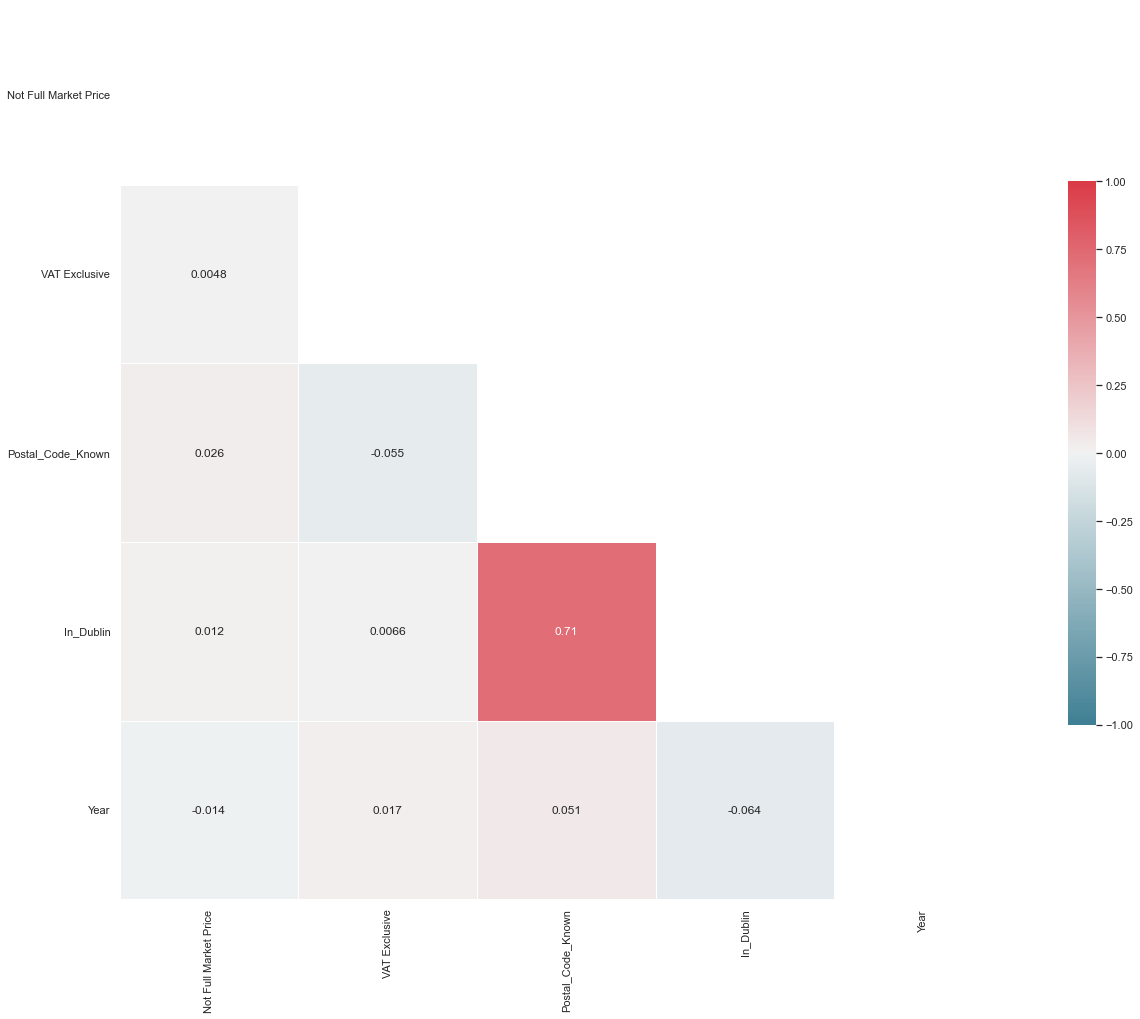

In [599]:
# Correlation matrix using code found on https://stanford.edu/~mwaskom/software/seaborn/examples/many_pairwise_correlations.html
sns.set(style="white")
continuous_columns = df.select_dtypes(['int64']).columns
df[continuous_columns].dtypes
# Calculate correlation of all pairs of continuous features
corr = X_train[continuous_columns].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 20))

# Generate a custom colormap - blue and red
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, vmax=1, vmin=-1,
            square=True, xticklabels=True, yticklabels=True,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)
plt.yticks(rotation = 0)
plt.xticks(rotation = 90)

#### Interpretation of the results
- Strong correlations -  We can see clearly from the above heat map that there are a number of features that have string correlations
    - 'In_Dublin' and 'Postal_Code_Known' (0.71) - This is to be expected as most post codes are "dublin xx", We only need to keep one of these features.
- Weak correlations - We can see a number of features with no apparent correlation to any other features
    - 'Not Full Market Price' - we will check this feature against the target later and if no strong correlation we can remove then
    - 'VAT Exclusive' - we will check this feature against the target later and if no strong correlation we can remove then
    - 'Year' - we will check this feature against the target later and if no strong correlation we can remove then

**Current status : Drop In_Dublin**
- We will label this as low_information_gain features

In [600]:
low_information_gain = ['In_Dublin']

### 1.2.2 Plot interaction between continuous features and target feature
- Here we will loop over each continuous feature and make a scatter plot against the target 'Price'
- We will discuss what we observe from these plots, e.g. which continuous features seem to be better at predicting the target feature
- We will choose a subset of continuous features we find promising (if any) and justify our choice.


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or R

,Price (€)
In_Dublin,0.419089
Postal_Code_Known,0.314132
Year,0.209885
VAT Exclusive,0.138129
Not Full Market Price,-0.138639


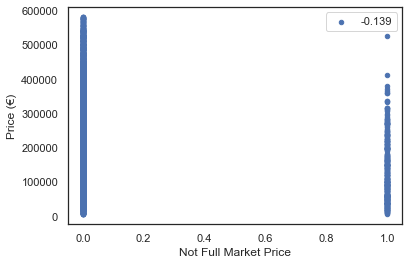

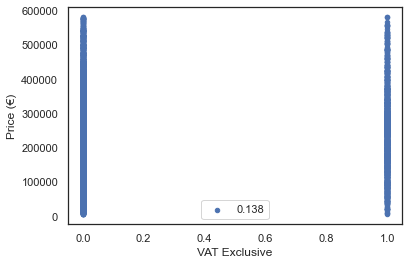

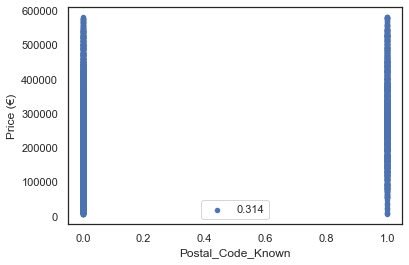

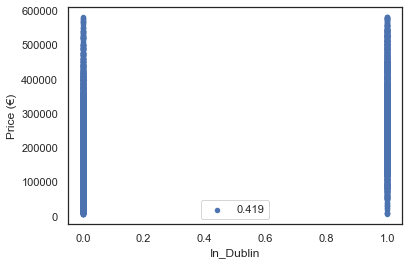

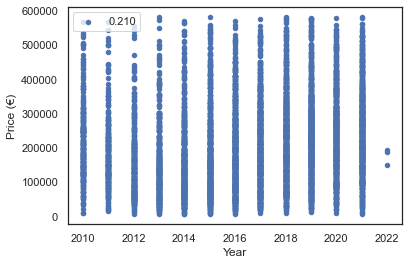

In [601]:
# dict to hold correlation values 
corr_dict = {}

# plot pairwise interaction between all continuous features and target
for column in X_train[continuous_columns]:
    # create temp df to merge column and target
    df_temp = pd.concat([X_train[column], y_train], axis=1)
    # store correlation in variable
    correlation = df_temp[[column, "Price (€)"]].corr().values[0,1]
    # plot the column and tartget feature
    df_temp.plot(kind='scatter', x=column, y="Price (€)", label="%.3f" % correlation)
    # add correlation to dict
    corr_dict[column] = correlation

# dataframe holding sorted correlation values to aid in interpreting results
corr_df = pd.DataFrame.from_dict(corr_dict, orient='index', columns=['Price (€)']).sort_values('Price (€)', ascending=False)
corr_df

#### 1.2.3 Interpretation of the results
- Observing the plots, visually there are no clearly defined correlations and this is probably to be expected with a complex problem like this. There are many interactions to take into account.
- Reviewing the sorted correlation dataframe we get a better overview of all the correlations. 
- We will breakdown the correlation values into 3 bins for purposes of interpretation taking only their absolute value into account
- Note: The bounds for each bin are arbitrary and for the purpose of splitting up the features only. 

| Low correlation | Medium correlation | High correlation |
|-----------------|--------------------|------------------|
| x <= 0.15       | 0.15 < x < 0.25    | x >= 0.25        |
| 2 features     | 1  features        | 3 features       |
| 33%             | 17%                | 50%              |


- The strongest correlations are "In_Dublin" and "Postal_Code_Known".
    - Postal_Code_Known makes sense here as it assumed to be a price factor applied to the house price based on their location
    - In_Dublin makes sense here as it assumed to be a price factor applied to the house price based on their location
- I will decide to keep the features that fall into the medium and high correlation bins. The low correlations values will likely have little effect on the outcome and make the model more complicated.
- The impact of this decision will be evaluated in part 5.


List of low correlation features

In [602]:
# generate list of features for low correlation bin
low_correlation_features = []
for key, value in corr_dict.items():
    if value < 0.15 and value > -0.15:
        low_correlation_features.append(key)
low_correlation_features

['Not Full Market Price', 'VAT Exclusive']

List of high correlation features

In [603]:
# generate list of features for high correlation bin
high_correlation_features = []
for key, value in corr_dict.items():
    if value > 0.25 or value < -0.25:
        high_correlation_features.append(key)
high_correlation_features

['Postal_Code_Known', 'In_Dublin']

### 1.2.3 Plot interaction between categorical features and target feature
- Here we will plot a pairwise interaction between each categorical feature against the target feature. 
- We will discuss what we observe from these plots, e.g., which categorical features seem to be better at predicting the target feature...
- We will choose a subset of categorical features we find promising (if any) and justify our choice.

Here we have 5 categorical features
- Address, Postal Code, County, Description of Property, Property Size Description
- A stacked bar plot for each categorical feature which have regular cardinalities will be created.

##### Create stacked bar plots for all categorical features which have regular cardinalities

Feature                              Unique Values
-------                              --------------- 

Postal Code                          23
County                               26
Description of Property              2
Property Size Description            4


<AxesSubplot:title={'center':'Price (€)'}, xlabel='[Property Size Description]'>

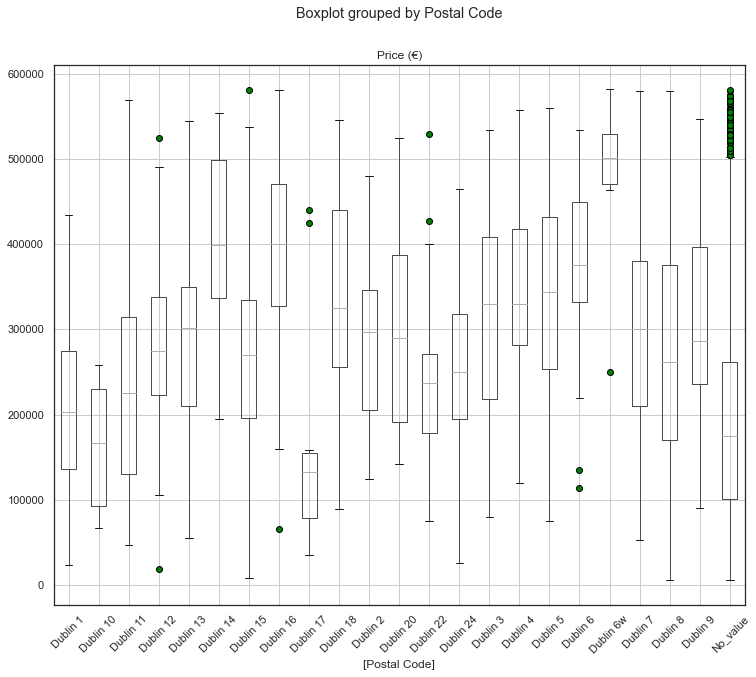

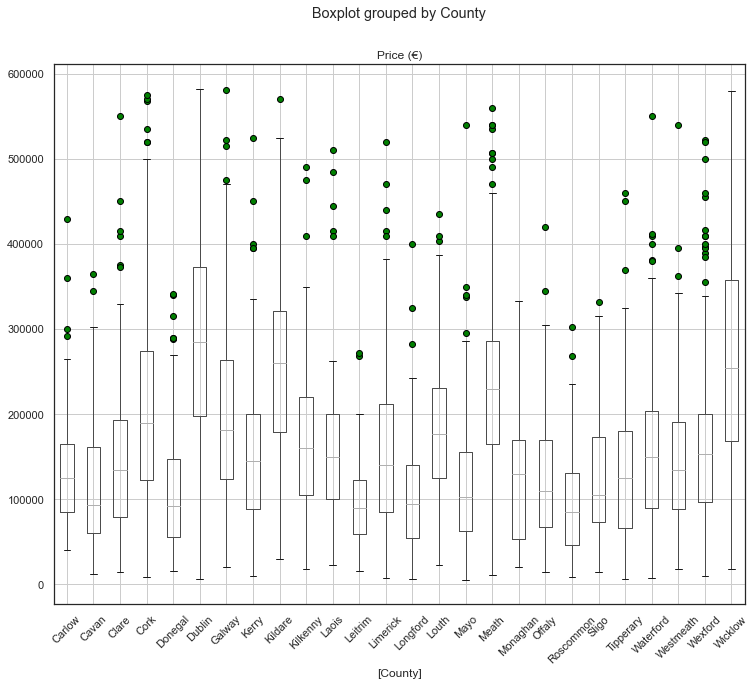

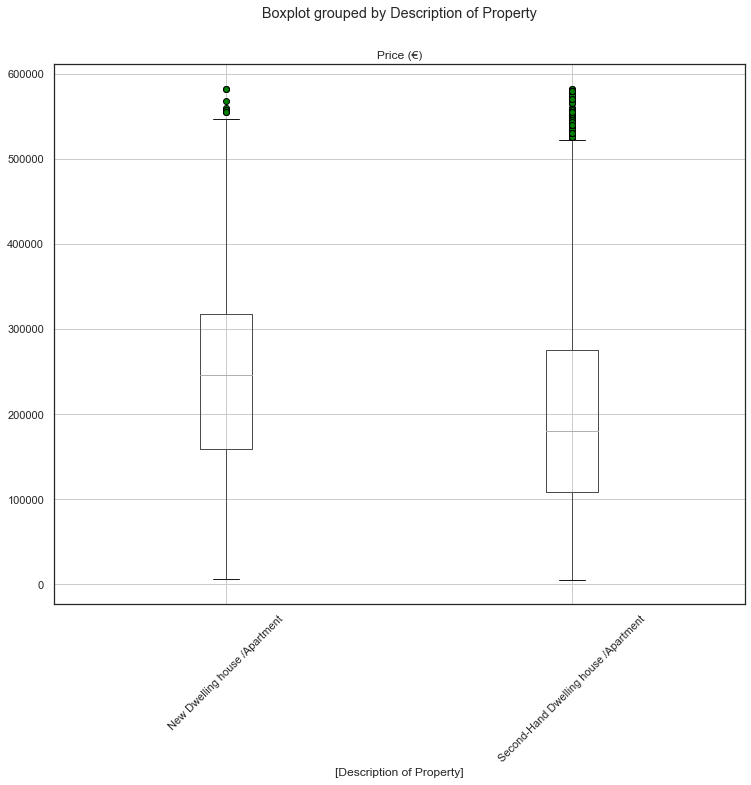

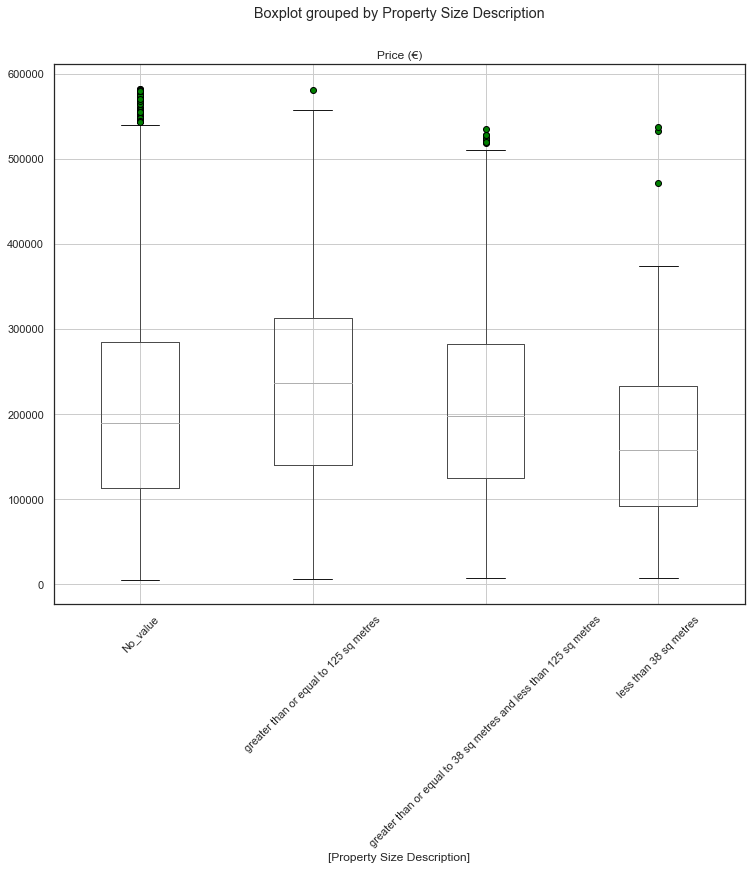

In [604]:
# Select columns containing categorical data
categorical_with_low_cardinality = ['Postal Code', 'County', 
                             'Description of Property', 'Property Size Description']

# we will create temp dataframe for these plots, mergeing X_train and y_train
df_temp= pd.concat([X_train, y_train], axis=1)

print('{0:35}  {1}'.format("Feature", "Unique Values"))
print('{0:35}  {1}'.format("-------", "--------------- \n"))
for c in categorical_with_low_cardinality:
    print('{0:35}  {1}'.format(c, str(len(df_temp[c].unique()))))

#plot bar plots for all features
flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_temp.boxplot(column=['Price (€)'], by=['Postal Code'], flierprops=flierprops, figsize=(12,10), rot=45)

flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_temp.boxplot(column=['Price (€)'], by=['County'], flierprops=flierprops, figsize=(12,10), rot=45)

flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_temp.boxplot(column=['Price (€)'], by=['Description of Property'], flierprops=flierprops, figsize=(12,10), rot=45)


flierprops = dict(marker='o', markerfacecolor='green', markersize=6,
                  linestyle='none')
df_temp.boxplot(column=['Price (€)'], by=['Property Size Description'], flierprops=flierprops, figsize=(12,10), rot=45)




#### Interpretation of the results
##### Price (€) vs Postal Code
- The graphs show that this feature still seems like a strong predictor. It is likely the price outcome will capture this data sufficiently.
##### Price (€) vs County
- The graphs show that this feature still seems like a strong predictor. It is likely the price outcome will capture this data sufficiently.
##### Price (€) vs Description of Property
- The graphs show that this feature still seems like a strong predictor. It is likely the price outcome will capture this data sufficiently.
##### Price (€) vs Property Size Description
- The graphs show that this feature still seems like a strong predictor. It is likely the price outcome will capture this data sufficiently.

**All 4 categorical features will be kept for now but it is expected that County and Postal Code will have the greater effect**

##### Further cleaning steps
Upon reivew of homework 1, we will now perform some additional cleaning and analysis steps which need to be carried out before proceeding with the steps involved in homework 2. These are:
- Address High cardinality 
- DateTime features

The first step in our further cleaning is to drop the feature 'AnimalID'as this is only needed for reference purposes and is not helpful in predictive modelling.

In [605]:
high_cardinality_features = ["Address"]
high_cardinality_features

['Address']

#### Date features
Next, for the datetime features Date of Sale (dd/mm/yyyy) some data integrity issues were dealt with in homework 1. Furthermore, in homework 1, some analysis was done of the month, day and hours of intake in a temporary dataframe, however, it was not deemed necessary at the time to split these features into categorical features representing the year, month and day. Before proceeding with predictive modelling we will now carry out this step. This step will make it easier to work with the high cardinality of the datetime features and it will convert them to a format which is easier to plots against the price outcome.

We begin this step by converting the feature Date of Sale (dd/mm/yyyy) into year, month and day features and drop the feature Date of Sale (dd/mm/yyyy).

In [606]:
df['Month']=df['Date of Sale (dd/mm/yyyy)'].dt.month
df['Day']=df['Date of Sale (dd/mm/yyyy)'].dt.day_name()
datetime_feature = ["Date of Sale (dd/mm/yyyy)"]

### 1.2.4 Summary & Drop Features

1. From Continuous vs Continuous plots (1.2.1) we identified the following to be dropped

In [607]:
low_information_gain

['In_Dublin']

2. From Continuous vs Target plots (1.2.2) we identified the following to be dropped

In [608]:
low_correlation_features

['Not Full Market Price', 'VAT Exclusive']

3. From Categorical vs Target (1.2.3) we identified the following to be dropped
    - None

We will now drop these features
- Before dropping we will duplicate the original dataframe, df, and label it df_rev1
- We will drop features from this copy only (df_rev1)
- This will allow us to revert to the original dataset later if we decide to compare the performance of the reduced dataset (df_rev1) with the original dataset (df)

In [609]:
# drop all low correlation features
low_value_features = list(set(low_information_gain + low_correlation_features + high_cardinality_features + datetime_feature))
# before dropping make copy of original
df_rev1 = df.copy()
# drop low value features
df_rev1.drop(low_value_features, 1, inplace=True)
print('\nRemaining columns:', df_rev1.columns)
print('\nNew shape:', df_rev1.shape)


Remaining columns: Index(['Postal Code', 'County', 'Price (€)', 'Description of Property',
       'Property Size Description', 'Postal_Code_Known', 'Year', 'Month',
       'Day'],
      dtype='object')

New shape: (9415, 9)


## 1.3 Prepare dataset for modeling
Now we have picked our descriptive features for the whole dataset, a number of additional steps will need to be taken to prepare the dataset for modeling 
- We will now convert the categorical variables into dummies variable to allow modeling
- We will then remove the redundant dummies which contain no additional information
- We will then set up the train test split again based on the dataset with the dummies included

In [610]:
df_rev1 = pd.get_dummies(df_rev1)
df_rev1.dtypes

Price (€)               float64
Postal_Code_Known         int64
Year                      int64
Month                     int64
Postal Code_Dublin 1      uint8
                         ...   
Day_Saturday              uint8
Day_Sunday                uint8
Day_Thursday              uint8
Day_Tuesday               uint8
Day_Wednesday             uint8
Length: 66, dtype: object

#### Continuous columns are:

In [611]:
continuous_columns = df_rev1.select_dtypes(include=['int64']).columns.tolist()
continuous_columns

['Postal_Code_Known', 'Year', 'Month']

#### Categorical columns are:

In [612]:
categorical_columns = df_rev1.select_dtypes(include=['uint8']).columns.tolist()
categorical_columns

['Postal Code_Dublin 1',
 'Postal Code_Dublin 10',
 'Postal Code_Dublin 11',
 'Postal Code_Dublin 12',
 'Postal Code_Dublin 13',
 'Postal Code_Dublin 14',
 'Postal Code_Dublin 15',
 'Postal Code_Dublin 16',
 'Postal Code_Dublin 17',
 'Postal Code_Dublin 18',
 'Postal Code_Dublin 2',
 'Postal Code_Dublin 20',
 'Postal Code_Dublin 22',
 'Postal Code_Dublin 24',
 'Postal Code_Dublin 3',
 'Postal Code_Dublin 4',
 'Postal Code_Dublin 5',
 'Postal Code_Dublin 6',
 'Postal Code_Dublin 6w',
 'Postal Code_Dublin 7',
 'Postal Code_Dublin 8',
 'Postal Code_Dublin 9',
 'Postal Code_No_value',
 'County_Carlow',
 'County_Cavan',
 'County_Clare',
 'County_Cork',
 'County_Donegal',
 'County_Dublin',
 'County_Galway',
 'County_Kerry',
 'County_Kildare',
 'County_Kilkenny',
 'County_Laois',
 'County_Leitrim',
 'County_Limerick',
 'County_Longford',
 'County_Louth',
 'County_Mayo',
 'County_Meath',
 'County_Monaghan',
 'County_Offaly',
 'County_Roscommon',
 'County_Sligo',
 'County_Tipperary',
 'County_W

#### Total features are:

In [613]:
features = continuous_columns + categorical_columns
features

['Postal_Code_Known',
 'Year',
 'Month',
 'Postal Code_Dublin 1',
 'Postal Code_Dublin 10',
 'Postal Code_Dublin 11',
 'Postal Code_Dublin 12',
 'Postal Code_Dublin 13',
 'Postal Code_Dublin 14',
 'Postal Code_Dublin 15',
 'Postal Code_Dublin 16',
 'Postal Code_Dublin 17',
 'Postal Code_Dublin 18',
 'Postal Code_Dublin 2',
 'Postal Code_Dublin 20',
 'Postal Code_Dublin 22',
 'Postal Code_Dublin 24',
 'Postal Code_Dublin 3',
 'Postal Code_Dublin 4',
 'Postal Code_Dublin 5',
 'Postal Code_Dublin 6',
 'Postal Code_Dublin 6w',
 'Postal Code_Dublin 7',
 'Postal Code_Dublin 8',
 'Postal Code_Dublin 9',
 'Postal Code_No_value',
 'County_Carlow',
 'County_Cavan',
 'County_Clare',
 'County_Cork',
 'County_Donegal',
 'County_Dublin',
 'County_Galway',
 'County_Kerry',
 'County_Kildare',
 'County_Kilkenny',
 'County_Laois',
 'County_Leitrim',
 'County_Limerick',
 'County_Longford',
 'County_Louth',
 'County_Mayo',
 'County_Meath',
 'County_Monaghan',
 'County_Offaly',
 'County_Roscommon',
 'Count

### Setting up the train/test split
- This is based on the dataset with dummy values
- The Target is stored in dataframe "y"
- The remaining features are stored in dataframe "X"
- Both are split into training and test subsets

In [614]:
# y is the target
y = df_rev1["Price (€)"]
# X is everything else
X = df_rev1.drop(["Price (€)"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1,  test_size=0.3)

print("original range is: ",df_rev1.shape[0])
print("training range (70%):\t rows 0 to", round(X_train.shape[0]))
print("test range (30%): \t rows", round(X_train.shape[0]), "to", round(X_train.shape[0]) + X_test.shape[0])

original range is:  9415
training range (70%):	 rows 0 to 6590
test range (30%): 	 rows 6590 to 9415


In [615]:
print("\nDescriptive features in X:\n", X_train.head(5))
print("\nTarget feature in y:\n", y_train.head(5))


Descriptive features in X:
       Postal_Code_Known  Year  Month  Postal Code_Dublin 1  \
9248                  1  2014      8                     0   
1477                  0  2015      7                     0   
8162                  1  2015     11                     0   
2608                  0  2013      4                     0   
6414                  0  2018      9                     0   

      Postal Code_Dublin 10  Postal Code_Dublin 11  Postal Code_Dublin 12  \
9248                      0                      0                      0   
1477                      0                      0                      0   
8162                      0                      0                      0   
2608                      0                      0                      0   
6414                      0                      0                      0   

      Postal Code_Dublin 13  Postal Code_Dublin 14  Postal Code_Dublin 15  \
9248                      0                      0        

#### Reset the indexes of the training and test splits
- We can see from the X_train printout below that the indexes are no longer consecutive
- This is the same for y_train, X_test, y_test
- This will need to be dealt with next as it will effect merging of dataframes in the coming sections

In [616]:
X_train.head(5)

,Postal_Code_Known,Year,Month,Postal Code_Dublin 1,Postal Code_Dublin 10,Postal Code_Dublin 11,Postal Code_Dublin 12,Postal Code_Dublin 13,Postal Code_Dublin 14,Postal Code_Dublin 15,...,Property Size Description_greater than or equal to 125 sq metres,Property Size Description_greater than or equal to 38 sq metres and less than 125 sq metres,Property Size Description_less than 38 sq metres,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
9248,1,2014,8,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1477,0,2015,7,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8162,1,2015,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2608,0,2013,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
6414,0,2018,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


We will now reset the index of all training and test dataframes

In [617]:
# need to reset the index to allow contatenation with predicted values otherwise not joining on same index...
X_train.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
X_train.head(5)

,Postal_Code_Known,Year,Month,Postal Code_Dublin 1,Postal Code_Dublin 10,Postal Code_Dublin 11,Postal Code_Dublin 12,Postal Code_Dublin 13,Postal Code_Dublin 14,Postal Code_Dublin 15,...,Property Size Description_greater than or equal to 125 sq metres,Property Size Description_greater than or equal to 38 sq metres and less than 125 sq metres,Property Size Description_less than 38 sq metres,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday
0,1,2014,8,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,2015,7,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,1,2015,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,2013,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,2018,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## (2) Linear Regression Model
#### 2.1 Train a linear regression model using only the descriptive features selected from part 1 above

In [618]:
# Train aka fit, a model using all continuous and categorical features.
multiple_linreg = LinearRegression().fit(X_train, y_train)

#### 2.2 Print out the coefficients learned by the model

In [619]:
# # Print the weights learned for each feature.
# print("\nFeatures are: \n", X_train.columns)
# print("\nCoeficients are: \n", multiple_linreg.coef_)
# print("\nIntercept is: \n", multiple_linreg.intercept_)
# print("\nFeatures and coeficients: \n", list(zip(X_train.columns, multiple_linreg.coef_)))

In [620]:
# Features and their respective coefficients
coeffs_df = pd.DataFrame(list(zip(X_train.columns, multiple_linreg.coef_)), columns = ['Features', 'Estimated_Coefficients'])
coeffs_df.sort_values(by='Estimated_Coefficients', ascending=False).tail(50)

,Features,Estimated_Coefficients
17,Postal Code_Dublin 3,2.303943e+15
22,Postal Code_Dublin 7,2.303943e+15
24,Postal Code_Dublin 9,2.303943e+15
14,Postal Code_Dublin 20,2.303943e+15
13,Postal Code_Dublin 2,2.303943e+15
7,Postal Code_Dublin 13,2.303943e+15
6,Postal Code_Dublin 12,2.303943e+15
23,Postal Code_Dublin 8,2.303943e+15
9,Postal Code_Dublin 15,2.303943e+15
16,Postal Code_Dublin 24,2.303943e+15


In [621]:
pos_coeffs_df= coeffs_df[(coeffs_df['Estimated_Coefficients'] <= 0)].sort_values(by='Estimated_Coefficients', ascending=False)
#pos_coeffs_df.sort_values(by='Estimated_Coefficients', ascending=False)
pos_coeffs_df

,Features,Estimated_Coefficients
2,Month,-196.495117


#### 2.2.1 Discussion: 

Before discussing the weights printout out above, we will first introduce linear regression. 

- Linear regression is a supervised machine learning method which is used to make predictions based on a linear relationship between the target (dependent variable) and any number of independent variables (also known as predictors).
- It finds the line of best fit that describes the relationship between the target and predictors. 
- The linear regression formula takes the following form:
    - $target\_feature = w_0 + w_1 * feature_1 + w_2*feature_2 + ...+ w_n*feature_n $
    
- In the formula, w_0, w_1 etc are known as the **model coefficients**. 
- To create the predictive model using linear regression, these coefficients must be "learned". 
- As seen in the image below, this is usually done using the **least squares criterion**. In other words, we find the line of best fit that describes the relationship between the target and predictors which minimises the **sum of squared residuals** (also known as sum of squared errors).
<br><img src="linear_regression.png" style="width: 300px;"/> <br>
Source: https://github.com/justmarkham/DAT4/blob/master/notebooks/08_linear_regression.ipynb

- We will now understand the image above: 
    - The **black** dots are the observed values of x and y.
    - The **blue line** is the least squares line. 
    - The **red lines** are the residuals. These are the distances between the observed values and the least squares line. It is these residuals that we try to minimise in linear regression.
    
- Linear regression is a regression task, which means that it predicts a numeric target feature. Thus, the output from the formula above is a continuous value that can be the predic price.
- It is important to note one of the downfalls of linear regression is that it is sensitive to outliers. However, this does not apply to our categorical features. 

**Discussing the coefficients learned by the model:**
- There are too many coefficients to discuss all in detail however we will explain their meaning and discuss some as an example. 
- We can see above that the intercept is -6786622664726975.0 (this is w_0 in the formula above). This is the value of y when x is zero. In other words it is where the model intercepts the x axis. If all other coefficients were zero, the model result would be -6786622664726975.0.
- We can see the coefficients for each feature above. They are zipped together in a single list for ease of visualisation and interpretation. We can see that some have negative values and some have positive values. 
- In general, the sign of a regression coefficient tells you whether there is a positive or negative correlation between each independent variable the dependent variable. A positive coefficient indicates that as the value of the independent variable increases, the mean of the dependent variable also tends to increase. A negative coefficient suggests that as the independent variable increases, the dependent variable tends to decrease.
- However, it is important to note that all of our features are categorical features which are dummy coded. Thus, care needs to be taken when interpreting the coefficients. The first value of each feature (which we have dropped) is the reference and each dummy is compared to the reference.
- For example, we see that Description of Property_New Dwelling house /Apartment' increases by 399314340526590, while Description of Property_Second-Hand Dwelling house increases by 399314340478799 which is smaller than new dwelling house. This makes sense as we saw in our barplot above. 
- Similarly, based on the values known from above, we can see that the reference value for *County* is *County_Dublin*. Thus, we can see that with reference to this value, houses with value *County_Dublin* are more likely to be expensive compared to house of *County_Kildare*.
- From the Exploratory analysis the top five features highly correlated with Sale Price are Day, Postal code, Property Size Description, County, Year.
-  This is quite surprising as to why would Month have negative correlation with the Sale Price


### 2.3 Printing 10 predicted target features and evaluate the prediction
- Here we will print the predicted target feature value for the first 10 training examples. 
- As discussed above, we will caculate the predicted target feature value given by the linear regression model at 0.5. This will give us the predicted class. 

In [622]:
multiple_linreg_predictions_train = (multiple_linreg.predict(X_train))

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_train, pd.DataFrame(multiple_linreg_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   Price (€)  Predicted
0    83000.0   210415.0
1   235000.0   188035.0
2   312000.0   355819.0
3   170000.0   211333.0
4   400000.0   228878.0
5   225000.0   244335.0
6   255506.5   250520.0
7   290000.0   300737.0
8   485000.0   198771.0
9   545000.0   248729.0


#### 2.3.1 Evaluation metrics based on training data
We will now print the classification evaluation measures computed on the training set. These are:
- R squared
- Mean Absolute Error
- Mean squared error
- RMSE
    
Although not required, as explained at https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/we will also include an additional evaluation metric known as *precision-recall area under the curve (PR-auc)*. We will describe this below when discussing all results.

In [623]:
#print evaluation measures
print("==================== Train Data =======================")
print('R squared: %.3f' %(multiple_linreg.score(X_train,y_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, multiple_linreg_predictions_train))
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, multiple_linreg_predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, multiple_linreg_predictions_train)))
print("======================================================")

==================== Train Data =======================
R squared: 0.378
Mean Absolute Error: 74362.90446585735
Mean squared error: 9317969451.16
RMSE: 96529.62991310621


**Regression Plot**

Let us draw a regression plot between the train target values and predicted train values to assess how the model is performing.

Text(0.5, 1.0, 'Regression Plot for Actual vs Predicted Values')

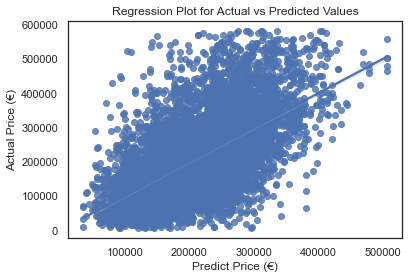

In [624]:
g = sns.regplot(x=multiple_linreg.predict(X_train), y=y_train, fit_reg=True)
g.set(xlabel='Predict Price (€)', ylabel='Actual Price (€)', title='Model Predictions')
plt.title('Regression Plot for Actual vs Predicted Values')

#### 2.3.2 Interpretation of results

We will now explain what each of the measures above means and will discuss our results. 

- **$R^2$**  It is the percentage of the response variable variation that is explained by a linear model. An $R^2$ of 0.378 is not a bad score to start with.
- **RMSE** It is the square root of the mean of squared errors. Squared errors are the difference of actual and predicted values sqaured. This model's RMSE is 96529, which is a bit high.

    
**Summary**
- The regression line appears to be a **good fit for the data**.
- However, the RMSE is quite high. This tells us that the model is not able to predict house price very accurately.

### 2.4 Evaluate the model using the hold-out (30% examples) test set
- The results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e. a new model trained and evaluated using cross-validation on the full dataset).

First, we will calculate the prediction. We will then print out the first 10 predicted values.

In [625]:
# calculate the prediction
multiple_linreg_predictions_test = (multiple_linreg.predict(X_test)) 

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelinreg = pd.concat([y_test, pd.DataFrame(multiple_linreg_predictions_test, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelinreg.head(10))


Predictions with multiple linear regression: 

   Price (€)  Predicted
0   245000.0   195855.0
1   427000.0   207331.0
2    80000.0   129045.0
3   259912.0   255359.0
4   121000.0   190220.0
5   310000.0   277412.0
6   205000.0   243977.0
7   330000.0   152798.0
8   185000.0   121056.0
9   191500.0   158695.0


#### 2.4.1 Compare training and test results.

We will now compute the test evaluation metrics and will compare to the training results. 

In [626]:
#print evaluation measures
print("==================== Test Data =======================")
print('R squared: %.3f' %(multiple_linreg.score(X_test,y_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, multiple_linreg_predictions_test))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, multiple_linreg_predictions_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, multiple_linreg_predictions_test)))
print("==================== Train Data =======================")
print('R squared: %.3f' %(multiple_linreg.score(X_train,y_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, multiple_linreg_predictions_train))
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, multiple_linreg_predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, multiple_linreg_predictions_train)))
print("======================================================")

==================== Test Data =======================
R squared: 0.350
Mean Absolute Error: 76861.87875044248
Mean squared error: 10034978738.88
RMSE: 100174.74102229408
==================== Train Data =======================
R squared: 0.378
Mean Absolute Error: 74362.90446585735
Mean squared error: 9317969451.16
RMSE: 96529.62991310621


**Regression Plot**

Let us draw a regression plot between the test target values and predicted test values to assess how the model is performing.

Text(0.5, 1.0, 'Regression Plot for Actual vs Predicted Values')

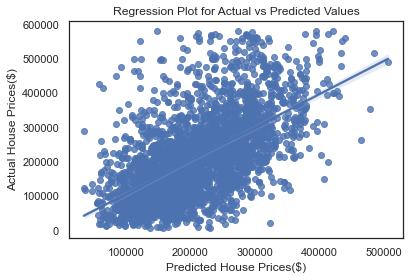

In [627]:
g = sns.regplot(x=multiple_linreg.predict(X_test), y=y_test, fit_reg=True)
g.set(xlabel='Predicted House Prices($)', ylabel='Actual House Prices($)', title='Model Predictions')
plt.title('Regression Plot for Actual vs Predicted Values')

#### 2.4.2 Interpretation of results

We will now explain what each of the measures above means and will discuss our results. 

- **$R^2$**  
- **RMSE** It is the square root of the mean of squared errors. Squared errors are the difference of actual and predicted values sqaured. This model's RMSE is 96529, which is a bit high.

    
**Summary**
-  The train set explains more varaince (37.8%) than the test set (35.0%). This is quite common because the model is trained on training data, training set's $R^2$ is always greater than the test set's $R^2$.
- The train and test scores not being too different form each other, indiactes that there is **no Overfitting**.
- From the graph above the model seems to be a good fit for the data, except for a few outliers in the houses highly priced.
- Clearly the **important features** that control the house price are the **Day, Postal code, Property Size Description, County, Year**

#### 2.4.3 Cross-validation

- We will now perform cross-validation on the linear regression model. 
- Using cross validation we do repeated train/test splits and average the error on the test datasets. Thus, it can result in a less biased result than a simple train/test split. 
- To perform cross-validation we will randomly split the dataset into 10 equal partitions. We will then use one partition as the test set and the union of all other partitions as the training set. We then evaluate the results of the test set. We will then repeat these steps using a different partition as the test set for each iteration. Finally, we will take the average of all results. 
- Throughout this assignment, we will use 10-fold as increasing this number would increase computation time. 

We will begin by creating a function to perform cross-validation as this is not provided by Scikit-Learn.

In [628]:
#this code is adapted from the sample solution provided, extra functionality has been added.
def cross_val_LinReg(X, y, cv=3, scoring='R_squared', resampled = None):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        if resampled == "resampled":
            X_train_resampled, y_train_resampled = over_sample_minority_linreg(X_train, y_train)
            # generate model
            multiple_linreg = LinearRegression().fit(X_train_resampled, y_train_resampled)
        elif resampled is None:
            multiple_linreg = LinearRegression().fit(X_train, y_train)
        # threshold
        multiple_linreg_predictions = multiple_linreg.predict(X_test) 
        # calc score
        if scoring=='R_squared':
            score = multiple_linreg.score(X_test,y_test)
        elif scoring=='MAR':
            score = metrics.mean_absolute_error(y_test, multiple_linreg_predictions_test)
        elif scoring=='MSE':
            score = mean_squared_error(y_test, multiple_linreg_predictions_test)
        elif scoring=='RMSE':
            score = np.sqrt(metrics.mean_squared_error(y_test, multiple_linreg_predictions_test))
        # append to results
        results.append(score)
    return results

- We will now create an additional function which will perform 10 fold cross validation and store results in a dataframe. This will done in order simplify further analysis the dataset, looking at R_squared, MAR, MSE, RMSE
- Within the cross validation functions for all models we will refer to PR-auc as *average_precision*. The reasoning for this will be explained in section 3 when we begin to use the Sklearn *cross_val_score()* method. 

In [629]:
#this code is from the sample solution provided
def cross_val_LinReg_DF(X,y, resampled=None):
    """Function to perform cross validation and store results 
    in dataframe. """

    linRegResults = {}
    # metrics to test against
    test_metrics = ['R_squared','MAR','MSE', 'RMSE']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_LinReg(X, y, cv=10, scoring=metric, resampled = resampled)
        length = len(result)
        # store result in dict
        linRegResults[metric] = sum(result)/length #np.std(result)]

    # create dataframe with results
    LinRegDF = pd.DataFrame.from_dict(linRegResults, orient='index', columns=['Linear_Regression Average' ])
    
    return LinRegDF

In [630]:
linRegDF = cross_val_LinReg_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
linRegDF

Mean results from 10 fold cross validation are:


,Linear_Regression Average
R_squared,3.610616e-01
MAR,1.122032e+05
MSE,2.006998e+10
RMSE,1.410083e+05




#### 2.4.2 Interpretation of cross-validation results. 
- Here we have the average of 10-fold cross-validations. 
- By default, Scikit-Learn outputs the results for the positive class.
- In comparison to the test results obtained above, we can see that the R squared has risen from 35% to 36.1%. while the MAR, MSE, RMSE has risen.
- We are pleased with these results. Although the recall score is lower than we would like, in comparison to the train data, we can see that the model is generalising well to new data. 

## (3) Decision Tree   

### 3.1 On the training set, train a decision tree model to predict the target feature, using the descriptive features selected in exercise (1) above.

We will now use the same feature set selected above to perform a decision tree using only the features selected above.

In [631]:
# Train aka fit, a model using all continuous and categorical features.
dtc_4 = DecisionTreeRegressor(max_depth=4, random_state=1)
dtc_10 = DecisionTreeRegressor(max_depth=10, random_state=1)
dtc_4.fit(X_train, y_train)
dtc_10.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=1)

### 3.2 interpret the decision tree model

- We will now interpret and discuss how the random forest model works. We will begin by explaining how random forests and decision trees work. We will then print two examples of decision trees and will interpret the results. 

**Decision Trees:**

- A decision tree begins with a feature as a node at the top of the tree which splits or branches out into different outcomes. These splits are based on the information gain. By default, Scikit-Learn measures this information gain using the Gini impurity. 
- As described at https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76, the Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled if it was labeled by the distribution of samples within the node. 
- The feature with the lowest Gini impurity will sit at the root of each decision tree. The tree will then always split on the feature that gives the lowest Gini impurity. In other words, a decision tree tries to form nodes containing a high proportion of samples from a single class. It does this by finding values in the features that cleanly divide the data into classes. 
- The splitting process is repeated until a stopping criteria is met (such as a maximum depth of the tree or the minimum number of samples in the leaf).
- The farthest branch on the tree represents the end result.



    
We will now look at an example of a single decision tree to get a better understanding

####  3.2.1  Train Decision tree
We will train 2 decision trees, with the same test data 
- One with max_depth=4 and the other max_depth=10
- Max depth determines how deep a decision tree can go before it must give an answer

In [632]:

print("Max depth 4: \n",dtc_4)
print("Max depth 10: \n",dtc_10)

Max depth 4: 
 DecisionTreeRegressor(max_depth=4, random_state=1)
Max depth 10: 
 DecisionTreeRegressor(max_depth=10, random_state=1)


####  3.2.2  Display Decision tree
We will create graph of each tree and store as an image

In [633]:
# create a Graphviz png
with open("DecisionTree4.dot", 'w') as f1:
    f1 = export_graphviz(dtc_4, out_file=f1, feature_names=X_train.columns)
with open("DecisionTree10.dot", 'w') as f2:
    f2 = export_graphviz(dtc_10, out_file=f2, feature_names=X_train.columns)
!dot -Tpng DecisionTree4.dot -o DecisionTree4.png
!dot -Tpng DecisionTree10.dot -o DecisionTree10.png

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.336444 to fit


<img src="DecisionTree4.png">

<img src="DecisionTree10.png">

For simplicity, we will only discuss the decision tree above with *max_depth=4*:
- We can see that the root node is *County_Dublin*. *samples* is equal to 6590 meaning that there are 6590 observations in this node. **value** shows the number of samples in each class. We can see that there are 209972. 
- This feature splits the data best and has the highest information gain. Houses that do not have a value <= 0.5 for * County_Dublin* (and thus is in Dublin) is the strongest predictor of the outcome in this dataset.
- We can see that the tree continues to split at the next best feature each time until the stopping criteria of max_depth=4 is met. 
- As mentioned above, this is only one example of a decision tree. 

In [634]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':dtc_10.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
31,County_Dublin,0.370910
1,Year,0.200100
2,Month,0.067743
53,Description of Property_Second-Hand Dwelling h...,0.042411
51,County_Wicklow,0.040915
...,...,...
28,County_Clare,0.000000
27,County_Cavan,0.000000
26,County_Carlow,0.000000
25,Postal Code_No_value,0.000000


###  3.3  Print the predicted target feature value for the first 10 training examples.
- Here we will print the predicted target feature value for the first 10 training examples. 

In [635]:
decision_tree_predictions_train = dtc_10.predict(X_train)

print("\nPredictions with multiple linear regression: \n")
actual_vs_predicted_multiplelogisticreg = pd.concat([y_train, pd.DataFrame(decision_tree_predictions_train, columns=['Predicted'])], axis=1)
print(actual_vs_predicted_multiplelogisticreg.head(10))


Predictions with multiple linear regression: 

   Price (€)      Predicted
0    83000.0  225739.471473
1   235000.0  149623.584237
2   312000.0  362900.000000
3   170000.0  156258.655625
4   400000.0  272687.500000
5   225000.0  322110.672167
6   255506.5  264552.715238
7   290000.0  278398.310294
8   485000.0  161948.063683
9   545000.0  277460.719417


#### 3.3.1 Evaluation metrics based on training data
- We will now print evaluation metrics computed on the full training set. As before, we will print R squared, Mean Absolute Error, Mean squared error, RMSE.
- We will discuss finding based on these measures

In [636]:
#print evaluation measures
print("==================== Train Data =======================")
print('R squared: %.3f' %(dtc_10.score(X_train,y_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, decision_tree_predictions_train))
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, decision_tree_predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, decision_tree_predictions_train)))
print("======================================================")

==================== Train Data =======================
R squared: 0.474
Mean Absolute Error: 66426.80512862225
Mean squared error: 7881725882.27
RMSE: 88779.08471182885


- As before, we will begin by discussing the **Confusion Matrix**:
    - We saw in linear that there was a high RMSE . 
    - Here, however, we have lower RMSE. This is a big improvement. 
- **R squared:** 
    - We have R squared of 47.4%
- **Mean Absolute Error:**
    - Mean Absolute Error is 66427
- **Mean squared error:**
    - Mean squared error is 7881725882
- **RMSE:**
    - RMSE is 88779
    
Summary: 
- Given the results we achieved for linear, these results show a large improvement in all scores.
- However, we must evaluate these results on test data in order to see how the model is generalising. Given how high these scores are, there is a risk that the model is overfitting which occurs when a model trains very well but does not generalise well to a new dataset.

### 3.4 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [637]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
dtc_predictions_test = dtc_10.predict(X_test)
dtc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': dtc_predictions_test})
dtc_predicted_test.head(10)

,ActualClass,PredictedClass
0,245000.0,215075.227273
1,427000.0,221529.926275
2,80000.0,112133.607178
3,259912.0,264552.715238
4,121000.0,204202.214667
5,310000.0,286034.383333
6,205000.0,225739.471473
7,330000.0,191175.097083
8,185000.0,137131.627976
9,191500.0,161948.063683


In [638]:
#print evaluation measures
print("==================== Train Data =======================")
print('R squared: %.3f' %(dtc_10.score(X_train,y_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, decision_tree_predictions_train))
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, decision_tree_predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, decision_tree_predictions_train)))
print("==================== Test Data =======================")
print('R squared: %.3f' %(dtc_10.score(X_test,y_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, dtc_predictions_test))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, dtc_predictions_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, dtc_predictions_test)))
print("======================================================")

==================== Train Data =======================
R squared: 0.474
Mean Absolute Error: 66426.80512862225
Mean squared error: 7881725882.27
RMSE: 88779.08471182885
==================== Test Data =======================
R squared: 0.267
Mean Absolute Error: 81414.57382584036
Mean squared error: 11319484294.18
RMSE: 106393.06506620672


#### 3.4.1 Interpretation of results and comparison with training set

We will now compare the test and training results.
- **R squared:** 
    - The R squared of the test data has decreased to 26.7%.
- **Mean Absolute Error:** 
    - Mean Absolute Error has increased from 66427 to 81414
- **Mean squared error:**
    - Mean squared Error has increased from 7881725882.27 to 11319484294.18
- **RMSE:**
    - RMSE has increased from 88779 to 106393

**Summary**


- The R squared for the test data is not high at 26.7%. However, most other scores have increased in comparison to the training data. 
- The results are reasonable considering that we are testing on data the model has not seen before. Most of the scores are in line with the scores seen on test data for linear regression.
- However, we were hoping for slightly higher scores given how high the training scores were. We will now perform cross-validation in order to further test the random forest model. 

#### 3.4.2 Cross validation
- We will preform cross validation and store the results in a dictionary for later use.

In [639]:
#this code is adapted from the sample solution provided, extra functionality has been added.
def cross_val_DT(X, y, cv=3, scoring='R_squared', resampled = None):
    """Functions to carry out cross validation on the linear regression model
    Default number of validations is 3. The randon state will be updated 
    at each iteration to allow our results to be repeated"""
    
    # store results
    results = []
    # evaluate cv times and append to results
    for i in range(cv):
        # set up train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=i , test_size=0.3)
        # generate model
        if resampled == "resampled":
            X_train_resampled, y_train_resampled = over_sample_minority_dt(X_train, y_train)
            # generate model
            multiple_dt = DecisionTreeRegressor(max_depth=10, random_state=1).fit(X_train_resampled, y_train_resampled)
        elif resampled is None:
            multiple_dt = DecisionTreeRegressor(max_depth=10, random_state=1).fit(X_train, y_train)
        # threshold
        multiple_dt_predictions = multiple_dt.predict(X_test) 
        # calc score
        if scoring=='R_squared':
            score = multiple_dt.score(X_test,y_test)
        elif scoring=='MAR':
            score = metrics.mean_absolute_error(y_test, multiple_dt_predictions)
        elif scoring=='MSE':
            score = mean_squared_error(y_test, multiple_dt_predictions)
        elif scoring=='RMSE':
            score = np.sqrt(metrics.mean_squared_error(y_test, multiple_dt_predictions))
        # append to results
        results.append(score)
    return results

In [640]:
#this code is from the sample solution provided
def cross_val_DecsionTree_DF(X,y, resampled=None):
    """Function to perform cross validation and store results 
    in dataframe. """

    DecisionTreeResults = {}
    # metrics to test against
    test_metrics = ['R_squared','MAR','MSE', 'RMSE']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_DT(X, y, cv=10, scoring=metric, resampled = resampled)
        length = len(result)
        # store result in dict
        DecisionTreeResults[metric] = sum(result)/length #np.std(result)]

    # create dataframe with results
    DecisionTreeDF = pd.DataFrame.from_dict(DecisionTreeResults, orient='index', columns=['Decision Tree Average' ])
    
    return DecisionTreeDF

In [641]:
DecisionTreeDF = cross_val_DecsionTree_DF(X,y)
print(f"Mean results from 10 fold cross validation are:")
DecisionTreeDF

Mean results from 10 fold cross validation are:


,Decision Tree Average
R_squared,2.575253e-01
MAR,8.125636e+04
MSE,1.137348e+10
RMSE,1.066267e+05


- We can see that in comparison to the test results above, the scores for R_squared have decreased slightly. MSE and RMSE have increased slightly. These variations are not expected as we are now performing 10-fold cross validation. 
- These results are not as good as expected. We had expected random forest to perform better than  linear as we are working with categorical data which is non-linear in nature. 

## (4) Random Forest Model

### 4.1 Train a random forest model using only the descriptive features selected from part 1 above.

- We will now train a random forest model on our data.
- As we are working on a prediction problem, we will use decision trees. 
- We use the RandomForestRegressor() function. 
- The random state will be set to 1 to allow the results to be repeated. This means that any ties between features will be split in the same way each time we run the code, thus giving us the same tree each time.

In [642]:
rfc = RandomForestRegressor(n_estimators=10, random_state=1, max_features='auto',oob_score=True)
rfc.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, oob_score=True, random_state=1)

### 4.2. Can you interpret the random forest model? Discuss any knowledge you can gain in regard of the working of this model.  
- We will now interpret and discuss how the random forest model works. We will begin by explaining how random forests and decision trees work. We will then print two examples of decision trees and will interpret the results. 
- A random forest is an ensemble of decision trees and so we will begin our discussion by explaining a Decision Tree.

**Decision Trees:**
- A decision tree begins with a feature as a node at the top of the tree which splits or branches out into different outcomes. These splits are based on the information gain. By default, Scikit-Learn measures this information gain using the Gini impurity. 
- As described at https://towardsdatascience.com/an-implementation-and-explanation-of-the-random-forest-in-python-77bf308a9b76, the Gini Impurity of a node is the probability that a randomly chosen sample in a node would be incorrectly labeled if it was labeled by the distribution of samples within the node. 
- The feature with the lowest Gini impurity will sit at the root of each decision tree. The tree will then always split on the feature that gives the lowest Gini impurity. In other words, a decision tree tries to form nodes containing a high proportion of samples from a single class. It does this by finding values in the features that cleanly divide the data into classes. 
- The splitting process is repeated until a stopping criteria is met (such as a maximum depth of the tree or the minimum number of samples in the leaf).
- The farthest branch on the tree represents the end result.
- We will discuss an example of a decision tree below. 
    
**Random Forest:**

- A random forest is made up of a number of decision trees.
- Random forest uses two important concepts: 
    - When training, each tree in a random forest learns from a random sample of the data points.
    - only a subset of all the features are considered for splitting each node in each decision tree. 
- The output of the random forest is then based on the majority output of all combined decision trees. 
- The random forest will keep track of the importance of features in terms of the information gain described above.


As mentioned in part 3, this is only one example of a decision tree. The random forest we have trained will be a combination of 100 decision trees.

Now that we have seen how decision trees work, we can now analyse the output from the random forest which we invoked above. 

- As mentioned above, the random forest keeps track of the importance of features.
- The list of importances are shown below. 
- The more important features are the features that the random forest has identified as having higher information gain. 
- The list is the combined result of the 100 decision trees which were used to train the random forest classifier. 
- This list will give us an idea of which features are the most important to keep as we move forward with our modelling. 

In [643]:
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False)

,feature,importance
31,County_Dublin,0.187971
2,Month,0.185098
1,Year,0.177584
58,Day_Friday,0.027612
62,Day_Thursday,0.026863
...,...,...
37,County_Leitrim,0.001573
21,Postal Code_Dublin 6w,0.001563
39,County_Longford,0.001480
4,Postal Code_Dublin 10,0.001273


We can list from the list of importances that many features provide little information gain. 

### 4.3 Print the predicted target feature value for the first 10 training examples.
- Here we will print the predicted target feature value for the first 10 training examples. 

In [644]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_train = rfc.predict(X_train)
df_true_vs_rfc_predicted = pd.DataFrame({'ActualClass': y_train, 'PredictedClass': rfc_predictions_train})
df_true_vs_rfc_predicted.head(10)

,ActualClass,PredictedClass
0,83000.0,185736.314000
1,235000.0,295000.000000
2,312000.0,376900.000000
3,170000.0,161500.000000
4,400000.0,347300.000000
5,225000.0,249635.300000
6,255506.5,272391.841667
7,290000.0,253700.000000
8,485000.0,270300.000000
9,545000.0,467750.000000


#### 3.3.1 Evaluation metrics based on training data
- We will now print evaluation metrics computed on the full training set. As before, we will print R squared, Mean Absolute Error, Mean squared error, RMSE.
- We will discuss finding based on these measures

In [645]:
#print evaluation measures
print("==================== Train Data =======================")
print('R squared: %.3f' %(rfc.score(X_train,y_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, rfc_predictions_train))
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, rfc_predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, rfc_predictions_train)))
print("======================================================")

==================== Train Data =======================
R squared: 0.806
Mean Absolute Error: 37920.71561493975
Mean squared error: 2908421837.06
RMSE: 53929.786176694375


- As before, we will begin by discussing the **Confusion Matrix**:
    - We saw in linear that there was a high RMSE . 
    - Here, however, we have lower RMSE. This is a big improvement. 
- **R squared:** 
    - We have R squared of 80.6%
- **Mean Absolute Error:**
    - Mean Absolute Error is 37920
- **Mean squared error:**
    - Mean squared error is 2908421837.06
- **RMSE:**
    - RMSE is 53929
    
Summary: 
- Given the results we achieved for linear and decision tree, these results show a large improvement in all scores.
- However, we must evaluate these results on test data in order to see how the model is generalising. Given how high these scores are, there is a risk that the model is overfitting which occurs when a model trains very well but does not generalise well to a new dataset.

### 4.4 Evaluate the model using the hold-out (30% examples) test set
- These results from the test data will be compared the results from the training data.
- In addition they will be compared to the results from a cross-validated model (i.e., a new model trained and evaluated using cross-validation on the full dataset).

In [646]:
# Predicted class labels for all examples, 
# using the trained model, on in-sample data (same sample used for training and test)
rfc_predictions_test = rfc.predict(X_test)
df_true_vs_rfc_predicted_test = pd.DataFrame({'ActualClass': y_test, 'PredictedClass': rfc_predictions_test})
df_true_vs_rfc_predicted_test.head(10)

,ActualClass,PredictedClass
0,245000.0,220631.000
1,427000.0,181200.000
2,80000.0,134378.989
3,259912.0,287250.000
4,121000.0,165975.000
5,310000.0,345915.500
6,205000.0,334500.000
7,330000.0,193290.000
8,185000.0,123312.700
9,191500.0,97800.000


In [647]:
#print evaluation measures
print("==================== Train Data =======================")
print('R squared: %.3f' %(rfc.score(X_train,y_train)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_train, rfc_predictions_train))
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, rfc_predictions_train))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, rfc_predictions_train)))
print("==================== Test Data =======================")
print('R squared: %.3f' %(rfc.score(X_test,y_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rfc_predictions_test))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, rfc_predictions_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfc_predictions_test)))
print("======================================================")

==================== Train Data =======================
R squared: 0.806
Mean Absolute Error: 37920.71561493975
Mean squared error: 2908421837.06
RMSE: 53929.786176694375
==================== Test Data =======================
R squared: 0.232
Mean Absolute Error: 83580.74200963233
Mean squared error: 11865720164.93
RMSE: 108929.88646340047


#### 4.4.1 Interpretation of results and comparison with training set

We will now compare the test and training results.
- **R squared:** 
    - The R squared of the test data has decreased to 23.2%.
- **Mean Absolute Error:** 
    - Mean Absolute Error has increased from 37920 to 83580
- **Mean squared error:**
    - Mean squared Error has increased from 2908421837 to 11865720164
- **RMSE:**
    - RMSE has increased from 53929 to 108929

**Summary**


- The R squared for the test data is not high at 23.2%. However, most other scores have increased in comparison to the training data. 
- The results are reasonable considering that we are testing on data the model has not seen before. Most of the scores are in line with the scores seen on test data for linear regression.
- However, we were hoping for slightly higher scores given how high the training scores were. We will now perform cross-validation in order to further test the random forest model. 

#### 4.4.2 Cross validation
- We will preform cross validation and store the results in a dictionary for later use.

In [648]:
#this code is adapted from the sample solution provided, extra functionality has been added.
def cross_val_RF(X, y, cv = 3, scoring='R_squared', depth = 10, estimators=10):
    
    # store results
    results = []
    # set up train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=0.3)
    # generate model
    for i in range(cv):
        multiple_rfc = RandomForestRegressor(n_estimators=estimators, random_state=i, max_features='auto',oob_score=True, max_depth=depth).fit(X_train, y_train)
        # threshold
        multiple_rfc_predictions = multiple_rfc.predict(X_test) 
        # calc score
        if scoring=='R_squared':
            score = multiple_rfc.score(X_test,y_test)
        elif scoring=='MAR':
            score = metrics.mean_absolute_error(y_test, multiple_rfc_predictions)
        elif scoring=='MSE':
            score = mean_squared_error(y_test, multiple_rfc_predictions)
        elif scoring=='RMSE':
            score = np.sqrt(metrics.mean_squared_error(y_test, multiple_rfc_predictions))
        # append to results
        results.append(score)
    return results

In [649]:
# #this code is from the sample solution provided
# def cross_val_RandomForest_DF(X,y, resampled=None):
#     """Function to perform cross validation and store results 
#     in dataframe. """

#     RandomForestResults = {}
#     # metrics to test against
#     test_metrics = ['R_squared','MAR','MSE', 'RMSE']
    
#     for metric in test_metrics:
#         # generate test results
#         result = cross_val_RF(X, y, cv=10, scoring=metric, resampled = resampled)
#         length = len(result)
#         # store result in dict
#         RandomForestResults[metric] = sum(result)/length #np.std(result)]

#     # create dataframe with results
#     RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random Forest Average' ])
    
#     return RandomForestDF

#this code is from the sample solution provided
def cross_val_RandomForest_DF(X,y, depth = 10, estimators=10):
    """Function to perform cross validation and store results 
    in dataframe. """

    RandomForestResults = {}
    # metrics to test against
    test_metrics = ['R_squared','MAR','MSE', 'RMSE']
    
    for metric in test_metrics:
        # generate test results
        result = cross_val_RF(X, y, cv=10, scoring=metric, depth = depth, estimators=estimators)
        length = len(result)
        # store result in dict
        RandomForestResults[metric] = sum(result)/length #np.std(result)]

    # create dataframe with results
    RandomForestDF = pd.DataFrame.from_dict(RandomForestResults, orient='index', columns=['Random Forest Average' ])
    
    return RandomForestDF

In [650]:
RandomForestDF = cross_val_RandomForest_DF(X,y)
print("Mean results from 10 fold cross validation are:")
RandomForestDF

Mean results from 10 fold cross validation are:


,Random Forest Average
R_squared,3.320192e-01
MAR,7.811813e+04
MSE,1.031595e+10
RMSE,1.015671e+05


- We can see that in comparison to the test results above, the scores for R_squared has decreased slightly. MAR and MSE have decreased obviously. These variations are expected as we are now performing 10-fold cross validation. 
- These results are not as good as expected. We had expected random forest to perform better than both decision tree and linear regression as we are working with categorical data which is non-linear in nature. 

This result is in line with the cross validation results seen above. We are happy with this result. 

# Q5) Improving predictive models

### 5.1 Which model of the ones trained above performs better at predicting the target feature? 

- In the cell below we will display the cross-validation results of all three models. We will discuss the findings below the output. 
- By default, the results shown here are for predicting the price
- It is important to note that these results are for a subset of the original features, as we dropped many features in part 1.
- Later in the assignment we will review the impact of removing these features. 

In [651]:
ResultsDF = pd.concat([linRegDF, DecisionTreeDF, RandomForestDF], axis=1)
ResultsDF

,Linear_Regression Average,Decision Tree Average,Random Forest Average
R_squared,3.610616e-01,2.575253e-01,3.320192e-01
MAR,1.122032e+05,8.125636e+04,7.811813e+04
MSE,2.006998e+10,1.137348e+10,1.031595e+10
RMSE,1.410083e+05,1.066267e+05,1.015671e+05


- There is quite a bit of variation in the scores.
- We can see that Decision Tree Average is performing the best. Although it does not have as high a R squared as linear regression, it has the lowest RMSE, MSE and MAR scores and thus is performing the best at predicting price.
- Random forests is the second best model.
- Although linear regression has a high R squared, the RMSE, MSE and MAR scores are lower than the other two models, telling us that it is not as good at predicting price.

#### 5.1.2 Is it more accurate than a simple model that always predicts the average price computed from the training set, for the same year as the test example？

- We will now compare our results to a simple model that always predicts the average price computed from the training set。
- We will now run some code which confirms this.

In [652]:
train_DF = pd.concat([X_train, y_train], axis=1)
test_DF = pd.concat([X_test, y_test], axis=1)
train_DF


,Postal_Code_Known,Year,Month,Postal Code_Dublin 1,Postal Code_Dublin 10,Postal Code_Dublin 11,Postal Code_Dublin 12,Postal Code_Dublin 13,Postal Code_Dublin 14,Postal Code_Dublin 15,...,Property Size Description_greater than or equal to 38 sq metres and less than 125 sq metres,Property Size Description_less than 38 sq metres,Day_Friday,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,Price (€)
0,1,2014,8,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,83000.0
1,0,2015,7,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,235000.0
2,1,2015,11,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,312000.0
3,0,2013,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,170000.0
4,0,2018,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,400000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6585,0,2013,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,160000.0
6586,0,2013,8,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,68000.0
6587,1,2021,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,580000.0
6588,0,2015,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,150000.0


then we need to caculate the mean price of each year

In [653]:

# Caculate the mean price of each year
year_mean = train_DF.groupby('Year')['Price (€)'].mean()
year_mean

Year
2010    215371.906534
2011    188596.824745
2012    159406.788698
2013    159182.289260
2014    165092.155981
2015    184161.438110
2016    198639.349542
2017    214822.931281
2018    228710.972841
2019    236727.017500
2020    242449.454477
2021    251138.238373
2022    176500.000000
Name: Price (€), dtype: float64

Now, we need to get the prediction of each test row

In [654]:
Years  = df['Year'].unique()

In [655]:
# for i in range(train_DF.shape[0]):
#     train_DF['Price (€)'][i] = year_mean[train_DF['Year'][i]]
# simple_prediction = train_DF['Price (€)']


In [656]:
for year in Years:
    test_DF.loc[(test_DF['Year'] == year),'Price (€)'] = year_mean[year]
simple_prediction = test_DF['Price (€)']

In [657]:
simple_prediction = pd.DataFrame(simple_prediction)
SimpleResults = {}

In [658]:

SimpleResults['R_squared'] = metrics.r2_score(y_test, simple_prediction)
SimpleResults['MAR'] = metrics.mean_absolute_error(y_test, simple_prediction)
SimpleResults['MSE'] = mean_squared_error(y_test, simple_prediction)
SimpleResults['RMSE'] = np.sqrt(metrics.mean_squared_error(y_test, simple_prediction))
SimpleResultsDT = pd.DataFrame.from_dict(SimpleResults, orient='index', columns=['Simple Average' ])
print('R squared: %.3f'%SimpleResults['R_squared'])
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, simple_prediction))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, simple_prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, simple_prediction)))



R squared: 0.062
Mean Absolute Error: 96091.53081686204
Mean squared error: 14492565742.85
RMSE: 120385.07275757553


In [659]:
ResultsDF = pd.concat([linRegDF, DecisionTreeDF, RandomForestDF, SimpleResultsDT], axis=1)
ResultsDF

,Linear_Regression Average,Decision Tree Average,Random Forest Average,Simple Average
R_squared,3.610616e-01,2.575253e-01,3.320192e-01,6.157376e-02
MAR,1.122032e+05,8.125636e+04,7.811813e+04,9.609153e+04
MSE,2.006998e+10,1.137348e+10,1.031595e+10,1.449257e+10
RMSE,1.410083e+05,1.066267e+05,1.015671e+05,1.203851e+05


- As mentioned above, by default sklearn outputs the cross-validation results for the positive class. 
-  When we create a simple model which always predicts the average price computed from the training set , the accuracy and R_squared scores are 6%. 

- Upon comparison with the scores obtained in our three models, we can see that our models perform better than this model which always predicts the average price computed from the training set. 
- Our results obtained were as followed: 
    - Linear regression: 
        - R_squared 36%
        - RMSE  141008
    - Decision Tree:
        - R_squared 25.8%
        - RMSE  106627.
    - Random Forests:
        - R_squared 33.8%
        - RMSE 101037.

### 5.2 Summarise your understanding of the problem and of your predictive modeling results so far.

The aim is to find a model which best predicts the price of the house. Based on this understanding, it is more important for our model to be able to predict the price. 

A critical feature of our dataset is that it is uncompleted. This makes it more difficult for us to predict house price. This has been reflected in our scores for all models. As we have discussed, county feature is the most important one for us to correctly predict. 

We will now link our understanding to the evaluation metrics in order to make it clear what the aim of part 5 is.
- **R squared** R-squared is a goodness-of-fit measure for linear regression models. This statistic indicates the percentage of the variance in the dependent variable that the independent variables explain collectively. R-squared measures the strength of the relationship between your model and the dependent variable on a convenient 0 – 100% scale.

- **Mean Absolute Error** Mean Absolute Error is a  model evaluation metric used with  regression models. The mean absolute error of a model with respect to a  test set is the mean of the absolute values of the individual prediction errors on over all  instances in the  test set. 


- ** MSE** Mean Squared Error ( MSE ) is defined as Mean or Average of the square of the difference between actual and estimated values. This means that MSE is calculated by the square of the difference between the predicted and actual target variables, divided by the number of data points. It is always non–negative values and close to zero are better.


- ** RMSE** Root Mean Square Error ( RMSE ) is also used as a measure for model evaluation. It is the square root of Mean Squared Error (MSE). This is the same as Mean Squared Error (MSE) but the root of the value is considered while determining the accuracy of the model. we will monitor this score throughout to ensure it does not increase significantly.

It is important to note that a discussion with the domain expert is needed in order to know exactly which scores to prioritise in the following analysis. Without such a discussion, we will assume that R squared is the most important for us to improve and that RMSE scores and average_precision much not increase in order to maintain a balance between R squared and RMSE. We are confident that by focussing on these metrics, we can improve the ability of the models to predict the price of a house and thus improve their outcome. 

### 5.2.1 New ideas to improve the best model so far.

#### All features
- The first step we will take is to compare our models to models using all features. 
- In part 1 we created a new dataframe containing only a subset of features and we preserved all features in the original dataframe. 
- We will now repeat the tests using all features.
- The first step is to set up the datadrame with all features but address(it has a high cardinality) and to create dummies. 

In [660]:
# dataframe with all features = original dataframe
df2 = df.copy()
df2 = df2.drop(['Address', 'Date of Sale (dd/mm/yyyy)'],1)
df_all = pd.get_dummies(df2, drop_first=True)
# set X,y
y = df_all["Price (€)"]
X = df_all.drop(["Price (€)"],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  63


- Now that we have created dummies on the dataset of all features, we are ready to test the models.
- Recall that in sections 2,3 and 4 above we created functions which return cross validation scores in dataframes.
- We will now invoke those functions in order to obtain the scores for all features. 

In [661]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
DecsionTreeDF = cross_val_DecsionTree_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, DecsionTreeDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression Average,Decision Tree Average,Random Forest Average
R_squared,3.766486e-01,2.910286e-01,3.455894e-01
MAR,1.122032e+05,7.963916e+04,7.742796e+04
MSE,2.006998e+10,1.085906e+10,1.010638e+10
RMSE,1.410083e+05,1.041987e+05,1.005301e+05


In [662]:
print("\nScores using all features:")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features:")
print("===================================================================")
print(ResultsDF)


Scores using all features:
           Linear_Regression Average  Decision Tree Average  \
R_squared               3.766486e-01           2.910286e-01   
MAR                     1.122032e+05           7.963916e+04   
MSE                     2.006998e+10           1.085906e+10   
RMSE                    1.410083e+05           1.041987e+05   

           Random Forest Average  
R_squared           3.455894e-01  
MAR                 7.742796e+04  
MSE                 1.010638e+10  
RMSE                1.005301e+05  

Scores using subset of features:
           Linear_Regression Average  Decision Tree Average  \
R_squared               3.610616e-01           2.575253e-01   
MAR                     1.122032e+05           8.125636e+04   
MSE                     2.006998e+10           1.137348e+10   
RMSE                    1.410083e+05           1.066267e+05   

           Random Forest Average  Simple Average  
R_squared           3.320192e-01    6.157376e-02  
MAR                 7.811813e

#### Discussion of results
- **Linear Regression:** We can see that R_squared decreased by 1.5% when the number of features was reduced. The other scores remained the same when the number of features was reduced
- **Decision Tree:** We can see that R_squared decreased by 3% when the number of features was reduced. While MAR decreased by 1600. MSE increased by 50000000. RMSE increased by 2500. 
- **Random Forests:** We can see that R_squared decreased by 0.7% when the number of features was reduced. While MAR decreased by 800. MSE increased by 100000000. RMSE increased by 500. 

- Although we do see an improvement in R_squared scores we see that there is no significant improvement in our R_squared when using our subset of features compared to all features. We see that the recall has only improved for random forests. It is difficult to say which feature set is performing better overall.
- In order to investigate which feature subset we should use in order to improve our models, in the cells below we investigate whether feature selection could provide us with a subset which would perform better than all features and the subset we have been using in parts 2,3 and 4.

### 5.2.1 Further cleaning of features
- Adding dates can improve the model, as transactions at the beginning and end of the month may have an impact on housing prices


In [663]:
df_feature_selection = df.copy()
df_feature_selection['Date'] = df_feature_selection['Date of Sale (dd/mm/yyyy)'].dt.day
df_feature_selection = df_feature_selection.drop(['Address', 'Date of Sale (dd/mm/yyyy)'],1)
df_feature_selection = pd.get_dummies(df_feature_selection, drop_first=True)
y = df_feature_selection["Price (€)"]
X = df_feature_selection.drop(['Price (€)'],1)
print("number of features incl dummies: ", len(X.columns))

number of features incl dummies:  64


In [664]:
# calculate Linear regression, logistic regression, random forest results again using all features
linRegDF = cross_val_LinReg_DF(X,y)
DecsionTreeDF = cross_val_DecsionTree_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y)
# merge all 3 models into dataframe
ResultsDF_allFeatures = pd.concat([linRegDF, DecsionTreeDF, RandomForestDF], axis=1)
ResultsDF_allFeatures

,Linear_Regression Average,Decision Tree Average,Random Forest Average
R_squared,3.761031e-01,2.680493e-01,3.454615e-01
MAR,1.122032e+05,8.075633e+04,7.753180e+04
MSE,2.006998e+10,1.121067e+10,1.010835e+10
RMSE,1.410083e+05,1.058720e+05,1.005396e+05


In [665]:
print("\nScores using all features:")
print("===================================================================")
print(ResultsDF_allFeatures)
print("\nScores using subset of features:")
print("===================================================================")
print(ResultsDF)


Scores using all features:
           Linear_Regression Average  Decision Tree Average  \
R_squared               3.761031e-01           2.680493e-01   
MAR                     1.122032e+05           8.075633e+04   
MSE                     2.006998e+10           1.121067e+10   
RMSE                    1.410083e+05           1.058720e+05   

           Random Forest Average  
R_squared           3.454615e-01  
MAR                 7.753180e+04  
MSE                 1.010835e+10  
RMSE                1.005396e+05  

Scores using subset of features:
           Linear_Regression Average  Decision Tree Average  \
R_squared               3.610616e-01           2.575253e-01   
MAR                     1.122032e+05           8.125636e+04   
MSE                     2.006998e+10           1.137348e+10   
RMSE                    1.410083e+05           1.066267e+05   

           Random Forest Average  Simple Average  
R_squared           3.320192e-01    6.157376e-02  
MAR                 7.811813e

We can see that append *date* improves the scores, R_squared has increased, and MAR, MSE, RMSE has decreased.

#### 5.2.2 Optimise Number of features
- First calculate feature order of importance using all features

In [666]:
# setup dataframe
y = df_feature_selection["Price (€)"]
X = df_feature_selection.drop(['Price (€)'],1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1 , test_size=0.3)
# Train RF with 100 trees
rfc = RandomForestRegressor(n_estimators=10, random_state=1, max_features='auto',oob_score=True)
rfc.fit(X_train, y_train)
importance = pd.DataFrame({'feature': X_train.columns, 'importance':rfc.feature_importances_})
importance.sort_values('importance', ascending=False, inplace=True)
importance.set_index('feature',1, inplace=True)
importance

,importance
feature,
Date,0.172070
Year,0.143725
County_Dublin,0.125325
Month,0.119085
In_Dublin,0.055738
...,...
Postal Code_Dublin 2,0.001600
County_Leitrim,0.001297
Postal Code_Dublin 10,0.000929


- Next calculate the optimum number of features
- There are 64 features in total (more due to dummy features)
- We will only calculate the top 20 features to keep the execution time down
- After the top 20 features we can see from the importance list that any additional features add little to no value
- We can see worst preforming features are the categorical which was not expected

**Note: This calculation may take some time**

In [667]:
# set up empty list to store features
list_features = []

# set up empty dataframe to store results
RandomForest_Features = pd.DataFrame()
count=0
for index, row in tqdm(importance.iterrows()):
    # only calculate the top 22 features to keep runtime down
    if count < 10:
        list_features.append(index)
        X = df_feature_selection[list_features]
        df1 = cross_val_RandomForest_DF(X,y)
        df1.rename(columns={'Random Forest Average':f'features={len(list_features)}'}, inplace=True)
        RandomForest_Features = pd.concat([RandomForest_Features, df1], axis=1)
        count+=1
    else:
        break

# to display all columns    
RandomForest_Features  

10it [00:23,  2.31s/it]


,features=1,features=2,features=3,features=4,features=5,features=6,features=7,features=8,features=9,features=10
R_squared,-4.022940e-03,3.068288e-02,2.145185e-01,1.969340e-01,1.969891e-01,2.378472e-01,2.559709e-01,2.650844e-01,2.655579e-01,2.669268e-01
MAR,1.005474e+05,9.735070e+04,8.666848e+04,8.756491e+04,8.754489e+04,8.537328e+04,8.373871e+04,8.284167e+04,8.285754e+04,8.277372e+04
MSE,1.550561e+10,1.496963e+10,1.213057e+10,1.240213e+10,1.240128e+10,1.177029e+10,1.149040e+10,1.134965e+10,1.134234e+10,1.132120e+10
RMSE,1.245215e+05,1.223503e+05,1.101385e+05,1.113642e+05,1.113604e+05,1.084907e+05,1.071930e+05,1.065344e+05,1.065000e+05,1.064009e+05


Here we see that after the top 30 features the R_squared of the model does not stabilise. Therefore was can not trim the model to the optimum number of features, we need to use all features 
- The top three feature from the random forest importance list are not  the top 3 correlated features from part 1 because we append *Date*, and its importance is top 1
- It is interesting to note that we achieve reasonable R_squared using top 3 features only. This had the highest correlation with the target and also the highest importance in the random forest model.

We can now define our list of optimum features is all features.

### 5.2.3 Optomise random forest
#### 5.2.3.1 Optomise max_depth
- Find the best performing max_depth of the decision tree while keeping the accuracy as high as possible. 
- In part 4, we trained a random forest with the Scikit-Learn default max_depth=10
- This means that the nodes will keep splitting until all nodes are pure (all data in the node comes from the same class)
- Generally, the deeper a tree goes, the more complex the model becomes. This can lead to overfitting because the model learns the training data very well and finds it difficult to generalise to new data. 
- We saw in section 4.6 that there was a significant decrease in scores between the training and test data. As a result, we will now explore the max_depth parameter in order to try and reduce overfitting. 

**NOTE: This execution may take a few minutes.**

In [668]:
y = df_feature_selection["Price (€)"]
X = df_feature_selection.drop(['Price (€)'],1)
# initialised empty daraframe
RandomForest_Depth = pd.DataFrame()

# calculate cross val score incrementing max depth by 1 each iteration
# append results to dataframe
for i in tqdm(range(1,20)):
    df1 = cross_val_RandomForest_DF(X,y,depth=i)
    df1.rename(columns={'Random Forest Average':f'depth={i}'}, inplace=True)
    RandomForest_Depth = pd.concat([RandomForest_Depth, df1], axis=1)

RandomForest_Depth

100%|██████████| 19/19 [01:35<00:00,  5.03s/it]


,depth=1,depth=2,depth=3,depth=4,depth=5,depth=6,depth=7,depth=8,depth=9,depth=10,depth=11,depth=12,depth=13,depth=14,depth=15,depth=16,depth=17,depth=18,depth=19
R_squared,1.864496e-01,2.472281e-01,2.776139e-01,3.005921e-01,3.176358e-01,3.330370e-01,3.416867e-01,3.467391e-01,3.484603e-01,3.454615e-01,3.429643e-01,3.363807e-01,3.268677e-01,3.204227e-01,3.119207e-01,3.053145e-01,2.985359e-01,2.940968e-01,2.866979e-01
MAR,8.992899e+04,8.540768e+04,8.304267e+04,8.147965e+04,8.027771e+04,7.904170e+04,7.824871e+04,7.773291e+04,7.746189e+04,7.753180e+04,7.763224e+04,7.792949e+04,7.843637e+04,7.866004e+04,7.906373e+04,7.937055e+04,7.958801e+04,7.982810e+04,8.026676e+04
MSE,1.256405e+10,1.162542e+10,1.115615e+10,1.080129e+10,1.053808e+10,1.030023e+10,1.016665e+10,1.008862e+10,1.006204e+10,1.010835e+10,1.014692e+10,1.024859e+10,1.039550e+10,1.049504e+10,1.062634e+10,1.072836e+10,1.083305e+10,1.090160e+10,1.101587e+10
RMSE,1.120895e+05,1.078211e+05,1.056226e+05,1.039291e+05,1.026549e+05,1.014897e+05,1.008296e+05,1.004418e+05,1.003092e+05,1.005396e+05,1.007315e+05,1.012347e+05,1.019578e+05,1.024448e+05,1.030833e+05,1.035768e+05,1.040809e+05,1.044096e+05,1.049555e+05


- We can see here that at a *max_depth* of 9, we get a R_squared score of 34.8%, RMSE 100441.
- At depths greater than 8 these scores decrease. Although these values will change slightly with different datasets, greater depths involves more computation. 

#### 5.2.3.1 Optomise the number of estimators

This parameter refers to the number of decision trees in the random forest. We will now try to find the optimum number. 

**NOTE: This execution may take a few minutes.**

In [669]:
#set up x and y 
y = df_feature_selection["Price (€)"]
X = df_feature_selection.drop(['Price (€)'],1)

# initialised empty daraframe
RandomForest_Estimators = pd.DataFrame()

n_estimators = [1, 2, 4, 8, 16, 32, 64, 70, 80, 100]

for item in tqdm(n_estimators):
    df1 = cross_val_RandomForest_DF(X,y,estimators=item)
    df1.rename(columns={'Random Forest Average':f'estimators={item}'}, inplace=True)
    RandomForest_Estimators = pd.concat([RandomForest_Estimators, df1], axis=1)

RandomForest_Estimators

100%|██████████| 10/10 [02:55<00:00, 17.50s/it]


,estimators=1,estimators=2,estimators=4,estimators=8,estimators=16,estimators=32,estimators=64,estimators=70,estimators=80,estimators=100
R_squared,2.168175e-01,2.874341e-01,3.246589e-01,3.419187e-01,3.507130e-01,3.548819e-01,3.567374e-01,3.572159e-01,3.577300e-01,3.581474e-01
MAR,8.380588e+04,8.052178e+04,7.860589e+04,7.776826e+04,7.720957e+04,7.695902e+04,7.682974e+04,7.680460e+04,7.676693e+04,7.673260e+04
MSE,1.209506e+10,1.100450e+10,1.042962e+10,1.016306e+10,1.002725e+10,9.962867e+09,9.934212e+09,9.926823e+09,9.918883e+09,9.912437e+09
RMSE,1.099660e+05,1.048992e+05,1.021232e+05,1.008112e+05,1.001356e+05,9.981391e+04,9.967046e+04,9.963339e+04,9.959355e+04,9.956119e+04


We are happy with the scores obtained using the value of 20 estimators, although greater estimators can improve the score,they involves more computation. In the cell below we will print the scores, combining the optomisation steps completed above. 

In [670]:
#set up x and y 
y = df_feature_selection["Price (€)"]
X = df_feature_selection.drop(['Price (€)'],1)
print("Number of features: ", len(X.columns))

# calculate Linear regression, logistic regression, random forest results again
linRegDF = cross_val_LinReg_DF(X,y)
logRegDF = cross_val_DecsionTree_DF(X,y)
RandomForestDF = cross_val_RandomForest_DF(X,y, depth=9, estimators=20)
# merge all 3 models into dataframe
ResultsDF_final = pd.concat([linRegDF, logRegDF, RandomForestDF], axis=1)
ResultsDF_final

Number of features:  64


,Linear_Regression Average,Decision Tree Average,Random Forest Average
R_squared,3.761031e-01,2.680493e-01,3.536752e-01
MAR,1.122032e+05,8.075633e+04,7.713994e+04
MSE,2.006998e+10,1.121067e+10,9.981503e+09
RMSE,1.410083e+05,1.058720e+05,9.990721e+04


### 5.2.4  Summary of all models

We will now compare our final results to those obtained from all features and our original subset above. We will summarise our final models below. 

In [671]:
print("\nScores using Scores using subset of features:")
print("===================================================================")
print(ResultsDF)

print("\nScores using optimum features:")
print("===================================================================")
print(ResultsDF_final)
print("\nScores using all features:")
print("===================================================================")
print(ResultsDF_allFeatures)



Scores using Scores using subset of features:
           Linear_Regression Average  Decision Tree Average  \
R_squared               3.610616e-01           2.575253e-01   
MAR                     1.122032e+05           8.125636e+04   
MSE                     2.006998e+10           1.137348e+10   
RMSE                    1.410083e+05           1.066267e+05   

           Random Forest Average  Simple Average  
R_squared           3.320192e-01    6.157376e-02  
MAR                 7.811813e+04    9.609153e+04  
MSE                 1.031595e+10    1.449257e+10  
RMSE                1.015671e+05    1.203851e+05  

Scores using optimum features:
           Linear_Regression Average  Decision Tree Average  \
R_squared               3.761031e-01           2.680493e-01   
MAR                     1.122032e+05           8.075633e+04   
MSE                     2.006998e+10           1.121067e+10   
RMSE                    1.410083e+05           1.058720e+05   

           Random Forest Average  

We can see that Random Forest is our best model. We have managed to increase the R_squared to 35.3% while keeping the RMSE at 100540. We are pleased with these results. Our aim was to improve a model so that it would be better at predicting the price of house. Based on our scores, we are confident that our model will help to achieve this. 

We have indeed managed to improve all scores in comparison to the dataset containing all features and to the feature set we were using in parts 2,3 and 4. More optomisation steps were involved in improving the random forest model than decision tree and so it is slightly more complex. 

We have managed to improve the recall of decision tree, however overall this model did not improve a lot. 

Considering the scores, we are happy to recommendRandom Forest as our best model and are confident that decision tree and Linear Regression would also perform well. 

## 5.3 Evaluate best model on new test set

We will now test our Random Forest model on a new dataset. This dataset has been cleaned in the homework1 notebook prior to being read in below. We will first perform the additional cleaning from part 1 of this assignment. 

### 5.3.1 Additional cleaning performed in part 1 of homework 2. 

First, we will read in the csv and drop the feature *percent*.

In [672]:
# read in the cleaned csv
df_test = pd.read_csv("22032022-PPR-Price-recent.csv", keep_default_na=True, delimiter=',', skipinitialspace=True)
df_test.columns

Index(['DateofSale(dd/mm/yyyy)', 'Address', 'PostalCode', 'County', 'Price(€)',
       'NotFullMarketPrice', 'VATExclusive', 'DescriptionofProperty',
       'PropertySizeDescription'],
      dtype='object')

In the cells below we will perform further cleaning on Address and the datetime features. 

In [673]:
df_test['Address'] = df_test['Address'].astype('category')
df_test['Price(€)'] = df_test['Price(€)'].astype(float)
df_test['PostalCode'] = df_test['PostalCode'].astype('category')
df_test['County'] = df_test['County'].astype('category')
df_test['DescriptionofProperty'] = df_test['DescriptionofProperty'].astype('category')
df_test['PropertySizeDescription'] = df_test['PropertySizeDescription'].astype('category')
# convert Not Full Market Price to 0,1
df_test['NotFullMarketPrice'] = df_test['NotFullMarketPrice'].map({'Yes': 1, "No": 0})
# convert VAT Exclusive to 0,1
df_test['VATExclusive'] = df_test['VATExclusive'].map({'Yes': 1, "No": 0})
# convert date features to datetime types
df_test['DateofSale(dd/mm/yyyy)'] = df_test['DateofSale(dd/mm/yyyy)'].astype('datetime64')
df_test['Month']=df_test['DateofSale(dd/mm/yyyy)'] .dt.month
df_test['Day']=df_test['DateofSale(dd/mm/yyyy)'] .dt.day_name()
df_test['Date'] = df_test['DateofSale(dd/mm/yyyy)'] .dt.day
df_test = df_test.drop(['Address', 'DateofSale(dd/mm/yyyy)'],1)
df_test.columns


Index(['PostalCode', 'County', 'Price(€)', 'NotFullMarketPrice',
       'VATExclusive', 'DescriptionofProperty', 'PropertySizeDescription',
       'Month', 'Day', 'Date'],
      dtype='object')

In [674]:
#replace missing values with 'No_value'
df_test['PropertySizeDescription'] = df_test['PropertySizeDescription'].astype('string')
df_test['PropertySizeDescription'] = df_test['PropertySizeDescription'].fillna("No_value")
df_test['PropertySizeDescription'] = df_test['PropertySizeDescription'].astype('category')

In [675]:
#replace missing values with 'No_value'
df_test['PostalCode'] = df_test['PostalCode'].astype('string')
df_test['PostalCode'] = df_test['PostalCode'].fillna("No_value")
df_test['PostalCode'] = df_test['PostalCode'].astype('category')

In [676]:
''' Detection '''
# IQR
Q1=df_test['Price(€)'].quantile(0.25)
Q3=df_test['Price(€)'].quantile(0.75)
IQR=Q3-Q1
 
print("Old Shape: ", df_test.shape)
 
test_4 = df_test[((df_test['Price(€)'] < Q1-1.5*IQR) |(df_test['Price(€)'] > Q3+1.5*IQR))]
# ''' Removing the Outliers '''
df_test.drop(test_4.index, inplace = True)
print("New Shape: ", df_test.shape)

Old Shape:  (7182, 10)
New Shape:  (6748, 10)


In [677]:
#create new feature equal to *Property Size Description*
df_test['Postal_Code_Known']=df_test['PostalCode']
#replace the value unknown with 0
df_test['Postal_Code_Known'] = df_test['Postal_Code_Known'].str.replace('No_value', 'No')
# if the value is not 0 set it to 1
df_test['Postal_Code_Known'][df_test['Postal_Code_Known'].str.contains('No')==0] = 'Yes'
#convert the new feature to category type
df_test['Postal_Code_Known'] = df_test['Postal_Code_Known'].astype('category')

#create new feature equal to *Property Size Description*
df_test['In_Dublin']=df_test['County']
# replace the value 'Dublin' with '1'
df_test['In_Dublin'] = df_test['In_Dublin'].str.replace('Dublin', '1')
# if the value is not 0 set it to 1
df_test['In_Dublin'][df_test['In_Dublin'].str.contains('1')==0] = '0'
#convert the new feature to category type
df_test['In_Dublin'] = df_test['In_Dublin'].astype('category')
df_test.isnull().sum()

PostalCode                 0
County                     0
Price(€)                   0
NotFullMarketPrice         0
VATExclusive               0
DescriptionofProperty      0
PropertySizeDescription    0
Month                      0
Day                        0
Date                       0
Postal_Code_Known          0
In_Dublin                  0
dtype: int64

### 5.3.2 Test the model on the cleaned dataset

In [678]:
# set up dummies features
df_test = pd.get_dummies(df_test, drop_first=True)
#set up x train and y train 
y = pd.DataFrame(df_test["Price(€)"])
X = df_test.drop(["Price(€)"],1)
# Split the dataset into two datasets: 70% training and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=1)
rfc_test = RandomForestRegressor(n_estimators=20,max_depth=9, random_state=1, max_features='auto',oob_score=True)
rfc_test.fit(X_train, y_train)

RandomForestRegressor(max_depth=9, n_estimators=20, oob_score=True,
                      random_state=1)

Next, we test the model on the new dataset using the features selected above.

In [679]:
rfc_predictions_df_test = rfc_test.predict(X_test)

In [680]:
#print evaluation measures
print("==================== Test Data =======================")
print('R squared: %.3f' %(rfc_test.score(X_test,y_test)))
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, rfc_predictions_df_test))
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, rfc_predictions_df_test))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, rfc_predictions_df_test)))
print("======================================================")

==================== Test Data =======================
R squared: 0.296
Mean Absolute Error: 89239.77504774087
Mean squared error: 13334768615.97
RMSE: 115476.26862680339


- We can see that our model is performing well on the test data. We are pleased with this as this is data that the model has never seen before. This shows that our model is generalising well to new data. 
- We can see that R squared is 29.6% while Mean Absolute Error is 89239 and RMSE is 115476. These are both good scores. 
- It appears that the features selected during feature selection in section 5.2.2 have trained our model well. 
- At the beginning of part 5 we discussed that our aim was to increase the R squared while maintaining low value for RMSE, Mean Absolute Error and MSE. We are pleased that we have achieved this. 

## Conclusion 

The aim of this assignment was to find a model which best predicts the price of a house. This was a difficult task given that lots of missing values of our dataset. We succeeded in improving our models throughout part 5 by exploring various optomisation techniques. Furthermore, we are pleased with how our logistic model has performed on a new dataset. 

